## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are a data scientist at a leading home electronics company specializing in advanced smart televisions. You aim to develop an innovative feature that enables the TV to recognize five distinct user gestures, allowing hands-free control without a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

| Gesture | Corresponding Action | Label |
| --- | --- | --- |
| Left Swipe | 'Jump' backwards 10 seconds. | 0 |
| Right Swipe | 'Jump' forward 10 seconds. | 1 |
| Stop | Pause the movie. | 2 |
| Thumbs Down | Decrease the volume. | 3 |
| Thumbs Up | Increase the volume. | 4 |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

### Project Setup:
To get started with the model building process, you first need to get the data on your storage. In order to get the data on the storage, perform the following steps in order

#### Steps:
    a. Open the terminal
    b. go down https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
    c. unzip Project_data.zip

The zip file was retrieved from Google Drive and extracted in the runtime environment to enable faster access and reference.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Instead of uploading the zip file in the runtime, reading it from Google Drive path and unzipping it in the runtime
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Project_data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Mounted at /content/drive


In [3]:
## Checking the GPU configuration
!nvidia-smi

Tue Mar 18 15:08:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Importing the necessary libraries

import numpy as np
import os
#from scipy.misc import imread, imresize
#from PIL import Image

import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof


import imageio as img
import tensorflow as tf

from imageio import imread
from tensorflow import keras
from keras import layers

Have set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [6]:
import cv2  # for image file reading and resizing
import matplotlib.pyplot as plt # for plotting the loss and accuracy related to training vs validation
#% matplotlib inline

In [7]:
from tensorflow import keras
#checking the tensorflow and keras versions for understanding the support from dependent libraries
print(keras.__version__)
print(tf.__version__)

3.8.0
2.18.0


Importing related libraries for building the model and related optimization -

In [8]:
# importing some other libraries which will be needed for model building.
#from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [9]:
project_folder='Project_data'

##### Plotting

In [10]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [11]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    # MOST IMPORTANT PART HERE - The generator function
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                #image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                #image_resized=image.resize(image,(self.image_height,self.image_width))
                image=cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR).astype(np.float32)
                image_resized=cv2.resize(image, (self.image_height,self.image_width))


                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0].astype(np.float32))/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1].astype(np.float32))/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2].astype(np.float32))/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0].astype(np.float32))/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1].astype(np.float32))/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2].astype(np.float32))/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [12]:
class ModelConv3D1(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=5,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 30, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 15, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 15, 80, 80, 32)      │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 15, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 7, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 7, 40, 40, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 7, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 3, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 3, 20, 20, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 3, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,736,389 (6.62 MB)

 Trainable params: 1,735,525 (6.62 MB)

 Non-trainable params: 864 (3.38 KB)

##### Sample Cropping

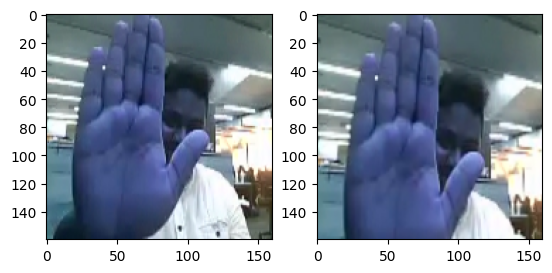

In [14]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

## Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
#conv_3d1.train_model(conv_3d1_model)

### Have hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...received the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [ ]:
#print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109538912773 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3328 - loss: 1.8414
Epoch 1: val_loss improved from inf to 2.20583, saving model to model_init_2025-03-1620_14_16.632172/model-00001-1.64330-0.38763-2.20583-0.23000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - categorical_accuracy: 0.3351 - loss: 1.8331 - val_categorical_accuracy: 0.2300 - val_loss: 2.2058 - learning_rate: 0.0010
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5408 - loss: 1.1628
Epoch 2: val_loss did not improve from 2.20583
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - categorical_accuracy: 0.5396 - loss: 1.1646 - val_categorical_accuracy: 0.1750 - val_loss: 3.6296 - learning_rate: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3991 - loss: 1.7433
Epoch 1: val_loss improved from inf to 3.47437, saving model to model_init_2025-03-1620_15_46.994858/model-00001-1.56143-0.42534-3.47437-0.16000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.3998 - loss: 1.7381 - val_categorical_accuracy: 0.1600 - val_loss: 3.4744 - learning_rate: 0.0010
Epoch 2/2
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5439 - loss: 1.1598
Epoch 2: val_loss did not improve from 3.47437
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.5440 - loss: 1.1589 - val_categorical_accuracy: 0.2200 - val_loss: 6.1166 - learning_rate: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4054 - loss: 1.7014
Epoch 1: val_loss improved from inf to 6.70838, saving model to model_init_2025-03-1620_19_15.788586/model-00001-1.47518-0.45098-6.70838-0.16000.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - categorical_accuracy: 0.4064 - loss: 1.6965 - val_categorical_accuracy: 0.1600 - val_loss: 6.7084 - learning_rate: 0.0010
Epoch 2/2
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5639 - loss: 1.1304
Epoch 2: val_loss did not improve from 6.70838
45/45 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - categorical_accuracy: 0.5644 - loss: 1.1286 - val_categorical_accuracy: 0.1333 - val_loss: 12.9197 - learning_rate: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3549 - loss: 1.8410
Epoch 1: val_loss improved from inf to 2.92157, saving model to model_init_2025-03-1620_22_19.555404/model-00001-1.61236-0.39668-2.92157-0.21000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - categorical_accuracy: 0.3566 - loss: 1.8315 - val_categorical_accuracy: 0.2100 - val_loss: 2.9216 - learning_rate: 0.0010
Epoch 2/2
22/23 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.5782 - loss: 1.0943
Epoch 2: val_loss did not improve from 2.92157
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - categorical_accuracy: 0.5794 - loss: 1.0938 - val_categorical_accuracy: 0.2167 - val_loss: 4.0594 - learning_rate: 0.0010


###Observations:
- As we see from the above experiments `image resolution` and `number of sampling frames` in sequence have more impact on training time than `batch_size`
- We can consider the Batch Size around 15-40
- We will change the resoulution 160*160, 120*120 according the model performance
- Also with increasing parameter size, the size of the model becoming complex and impacting on higher value loss, making the model less effective for validation

## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [ ]:
class ModelConv3D1(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 5, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 2, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 2, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │         819,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,117,061 (4.26 MB)

 Trainable params: 1,116,325 (4.26 MB)

 Non-trainable params: 736 (2.88 KB)

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3154 - loss: 1.8658
Epoch 1: val_loss improved from inf to 1.85384, saving model to model_init_2025-03-1620_24_48.547683/model-00001-1.65018-0.38009-1.85384-0.22000.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - categorical_accuracy: 0.3190 - loss: 1.8539 - val_categorical_accuracy: 0.2200 - val_loss: 1.8538 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.6239 - loss: 1.0673
Epoch 2: val_loss did not improve from 1.85384
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - categorical_accuracy: 0.6241 - loss: 1.0638 - val_categorical_accuracy: 0.2500 - val_loss: 1.9975 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6992 - loss: 0.7806
Epoch 3: val_loss did not improve from 1.85384
17/17 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - categorical_accuracy: 0.6981 - loss: 0.7811 - val_categorical_accuracy: 0.1750 - val_loss: 2.9577 - learning_rate: 0.0010
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.7508 - loss: 0.6526
Epoch 4: val_loss did not improve from 1.85384
17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - categorical_accuracy: 0.7509 - loss: 0.6529

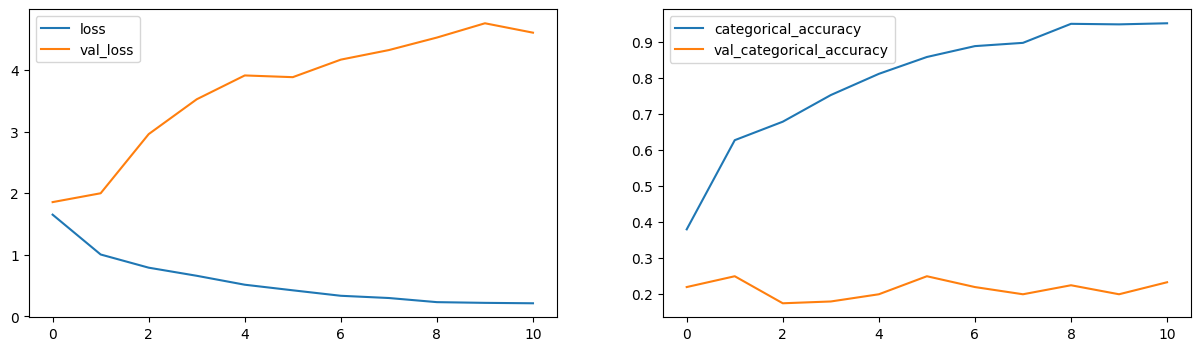

In [ ]:
plot(history_model1)

##### Model is clearly overfitting. :(

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)                    │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 5, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 2, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 2, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,638,981 (13.88 MB)

 Trainable params: 3,637,477 (13.88 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3815 - loss: 1.9807
Epoch 1: val_loss improved from inf to 2.48128, saving model to model_init_2025-03-1620_47_25.788451/model-00001-1.75696-0.43062-2.48128-0.19000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - categorical_accuracy: 0.3829 - loss: 1.9743 - val_categorical_accuracy: 0.1900 - val_loss: 2.4813 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5325 - loss: 1.3125
Epoch 2: val_loss did not improve from 2.48128
34/34 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - categorical_accuracy: 0.5325 - loss: 1.3138 - val_categorical_accuracy: 0.2500 - val_loss: 3.6651 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5482 - loss: 1.2429
Epoch 3: val_loss did not improve from 2.48128
34/34 ━━━━━━━━━━━━━━━━━━━━ 98s 3s/step - categorical_accuracy: 0.5492 - loss: 1.2403 - val_categorical_accuracy: 0.1600 - val_loss: 4.5998 - learning_rate: 0.0010
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5979 - loss: 1.0530
Epoch 4: val_loss did not improve from 2.48128
34/34 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - categorical_accuracy: 0.5985 - loss: 1.0525

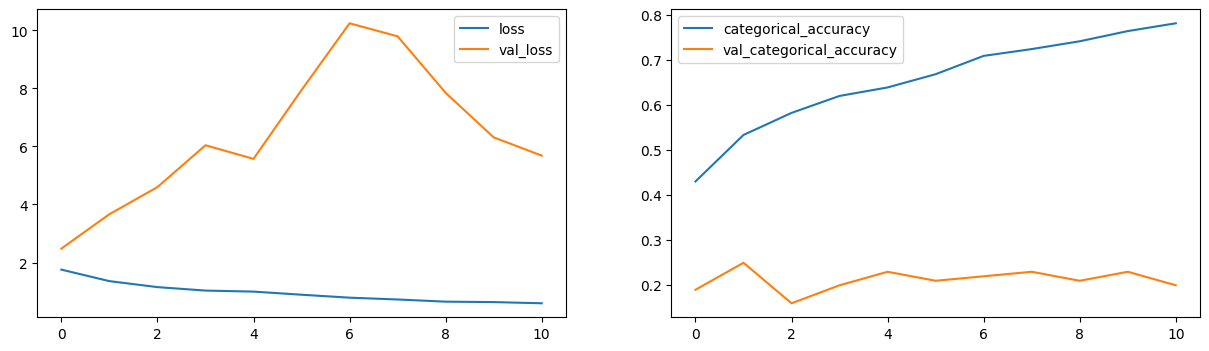

In [ ]:
plot(history_model2)

##### Clearly, 'val_loss' did not improve from ~4 to ~6 so earlystopping stops the epoch automatically!!
- Last Epoch stop on 11/25!! great job with earlystopping to save expensive resource cycles ;)
- Best weights save automatically. The validation accuracy of ~20-25% and training accuracy of ~70%. Next will try to reduce the filter size and image resolution and see if I get better results. Moreover since I see minor oscillations in loss, let me try lowering the learning rate to 0.0002

## Model 3
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [ ]:
class ModelConv3D3(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_16 (Conv3D)                   │ (None, 16, 120, 120, 16)    │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 8, 60, 60, 32)       │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_17 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_18 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_18 (MaxPooling3D)      │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_19 (Conv3D)                   │ (None, 2, 15, 15, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 2, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 2, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_19 (MaxPooling3D)      │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,762,613 (6.72 MB)

 Trainable params: 1,761,109 (6.72 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3057 - loss: 2.2139
Epoch 1: val_loss improved from inf to 1.99355, saving model to model_init_2025-03-1621_12_23.190122/model-00001-2.08007-0.34087-1.99355-0.16000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - categorical_accuracy: 0.3072 - loss: 2.2083 - val_categorical_accuracy: 0.1600 - val_loss: 1.9935 - learning_rate: 2.0000e-04
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4781 - loss: 1.5076
Epoch 2: val_loss did not improve from 1.99355
23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - categorical_accuracy: 0.4785 - loss: 1.5082 - val_categorical_accuracy: 0.1583 - val_loss: 2.7983 - learning_rate: 2.0000e-04
Epoch 3/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.5213 - loss: 1.2883
Epoch 3: val_loss did not improve from 1.99355
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - categorical_accuracy: 0.5238 - loss: 1.2862 - val_categorical_accuracy: 0.1500 - val_loss: 3.6174 - learning_rate: 2.0000e-04
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5696 - loss: 1.1304
Epoch 4: val_loss did not improve from 1.99355
23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - categorical_accuracy: 0.5701 - l

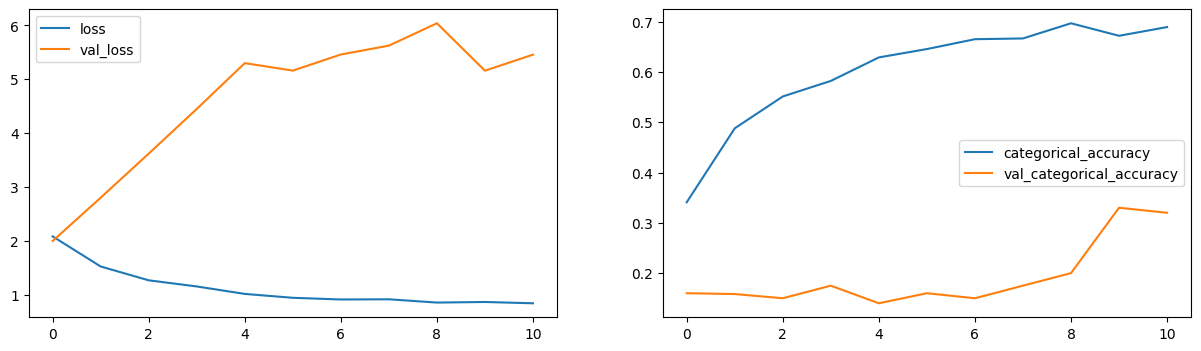

In [ ]:
plot(history_model3)

##### Model has a  best validation accuracy of 33% and training accuracy of 90% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 -
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [ ]:
class ModelConv3D4(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_21 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_20 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_22 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_23 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_21 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_24 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_25 (Conv3D)                   │ (None, 4, 30, 30, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 4, 30, 30, 64)       │              

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2937 - loss: 2.2635
Epoch 1: val_loss improved from inf to 2.90455, saving model to model_init_2025-03-1621_28_26.008633/model-00001-2.01418-0.34540-2.90455-0.23000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - categorical_accuracy: 0.2952 - loss: 2.2564 - val_categorical_accuracy: 0.2300 - val_loss: 2.9046 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4410 - loss: 1.6555
Epoch 2: val_loss improved from 2.90455 to 1.44262, saving model to model_init_2025-03-1621_28_26.008633/model-00002-1.54249-0.46531-1.44262-0.46000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - categorical_accuracy: 0.4417 - loss: 1.6523 - val_categorical_accuracy: 0.4600 - val_loss: 1.4426 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5256 - loss: 1.3502
Epoch 3: val_loss did not improve from 1.44262
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.5261 - loss: 1.3495 - val_categorical_accuracy: 0.2100 - val_loss: 3.4377 - learning_rate: 0.0010
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5639 - loss: 1.2053
Epoch 4: val_loss did not improve from 1.44262
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - categorical_accuracy: 0.5644 - loss: 1.2045 - val_categorical_accuracy: 0.3300 - val_loss: 2.0168 - learning_rate: 0.0010
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6308 - loss: 1.0051
Epoch 5: val_loss did not improve from 1.44262
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - categorical_accuracy: 0.6305 - loss: 1.0063 

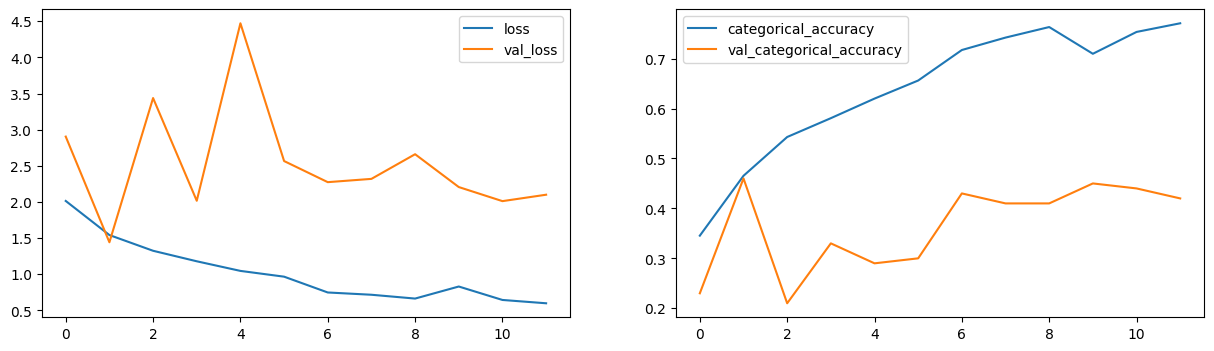

In [ ]:
plot(history_model4)

##### With more layers, I dont see much performance improvement. Received a best validation accuracy of 45% , training accuracy of 76%. Let's try adding dropouts at the convolution layers in the next model.

## Model 5
### Adding dropout at convolution layers

In [ ]:
class ModelConv3D5(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_29 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_24 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_30 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_31 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_25 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_32 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3616 - loss: 1.8982
Epoch 1: val_loss improved from inf to 2.34508, saving model to model_init_2025-03-1621_45_44.788276/model-00001-1.69210-0.41176-2.34508-0.21000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - categorical_accuracy: 0.3630 - loss: 1.8923 - val_categorical_accuracy: 0.2100 - val_loss: 2.3451 - learning_rate: 0.0010
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5703 - loss: 1.2093
Epoch 2: val_loss did not improve from 2.34508
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - categorical_accuracy: 0.5700 - loss: 1.2097 - val_categorical_accuracy: 0.2700 - val_loss: 2.6505 - learning_rate: 0.0010
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5854 - loss: 1.0816
Epoch 3: val_loss did not improve from 2.34508
34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - categorical_accuracy: 0.5858 - loss: 1.0808 - val_categorical_accuracy: 0.2000 - val_loss: 3.5114 - learning_rate: 0.0010
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6401 - loss: 0.9659
Epoch 4: val_loss did not improve from 2.34508
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - categorical_accuracy: 0.6402 - loss: 0.9664 

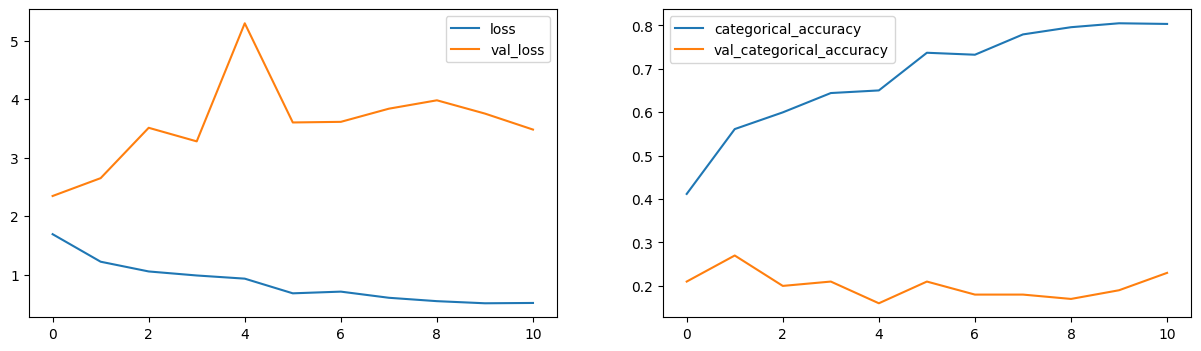

In [ ]:
plot(history_model5)

 __Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.__

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6
### Reducing the number of parameters

In [ ]:
class ModelConv3D6(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_40 (Conv3D)                   │ (None, 16, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_40 (Activation)           │ (None, 16, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 16, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_32 (MaxPooling3D)      │ (None, 8, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_41 (Conv3D)                   │ (None, 8, 50, 50, 32)       │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_41 (Activation)           │ (None, 8, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 8, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_33 (MaxPooling3D)      │ (None, 4, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_42 (Conv3D)                   │ (None, 4, 25, 25, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_42 (Activation)           │ (None, 4, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 4, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_34 (MaxPooling3D)      │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_43 (Conv3D)                   │ (None, 2, 12, 12, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 2, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 2, 12, 12, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_35 (MaxPooling3D)      │ (None, 1, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 696,645 (2.66 MB)

 Trainable params: 695,653 (2.65 MB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2639 - loss: 2.0489
Epoch 1: val_loss improved from inf to 1.87250, saving model to model_init_2025-03-1622_02_40.204127/model-00001-1.78546-0.33937-1.87250-0.25000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - categorical_accuracy: 0.2660 - loss: 2.0414 - val_categorical_accuracy: 0.2500 - val_loss: 1.8725 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5450 - loss: 1.1919
Epoch 2: val_loss did not improve from 1.87250
34/34 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - categorical_accuracy: 0.5452 - loss: 1.1916 - val_categorical_accuracy: 0.2300 - val_loss: 2.5775 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6250 - loss: 0.9454
Epoch 3: val_loss did not improve from 1.87250
34/34 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - categorical_accuracy: 0.6251 - loss: 0.9463 - val_categorical_accuracy: 0.2000 - val_loss: 3.6923 - learning_rate: 2.0000e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6538 - loss: 0.8806
Epoch 4: val_loss did not improve from 1.87250
34/34 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - categorical_accuracy: 0.6538 - l

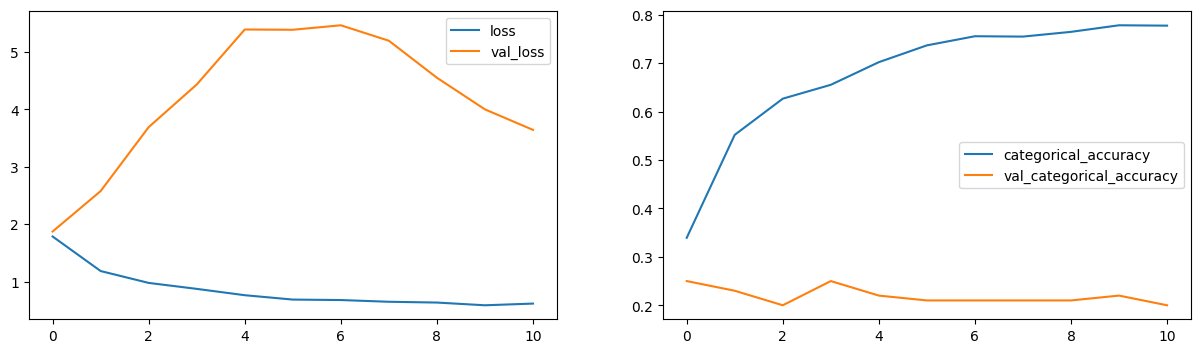

In [ ]:
plot(history_model6)

###### For the above low memory foot print model, we still see a very high loss and though the training accuracy is ~70% , the validation accuracy is still very low ~20%.

## Model 7 - Reducing the number of parameters again

In [ ]:
class ModelConv3D7(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_48 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_48 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_68               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_40 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_49 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_49 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_69               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_41 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_50 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_50 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_70               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_42 (MaxPooling3D)      │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_51 (Conv3D)                   │ (None, 2, 15, 15, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_51 (Activation)           │ (None, 2, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_71               │ (None, 2, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_43 (MaxPooling3D)      │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_72               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 504,709 (1.93 MB)

 Trainable params: 503,973 (1.92 MB)

 Non-trainable params: 736 (2.88 KB)

In [ ]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3005 - loss: 2.0394
Epoch 1: val_loss improved from inf to 1.85461, saving model to model_init_2025-03-1622_17_12.765424/model-00001-1.78600-0.35747-1.85461-0.16000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - categorical_accuracy: 0.3021 - loss: 2.0321 - val_categorical_accuracy: 0.1600 - val_loss: 1.8546 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4903 - loss: 1.4058
Epoch 2: val_loss did not improve from 1.85461
34/34 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - categorical_accuracy: 0.4909 - loss: 1.4035 - val_categorical_accuracy: 0.1800 - val_loss: 2.3773 - learning_rate: 2.0000e-04
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6013 - loss: 1.0084
Epoch 3: val_loss did not improve from 1.85461
34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.6014 - loss: 1.0087 - val_categorical_accuracy: 0.1500 - val_loss: 3.5980 - learning_rate: 2.0000e-04
Epoch 4/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - categorical_accuracy: 0.6570 - loss: 0.8823
Epoch 4: val_loss did not improve from 1.85461
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.6562 - l

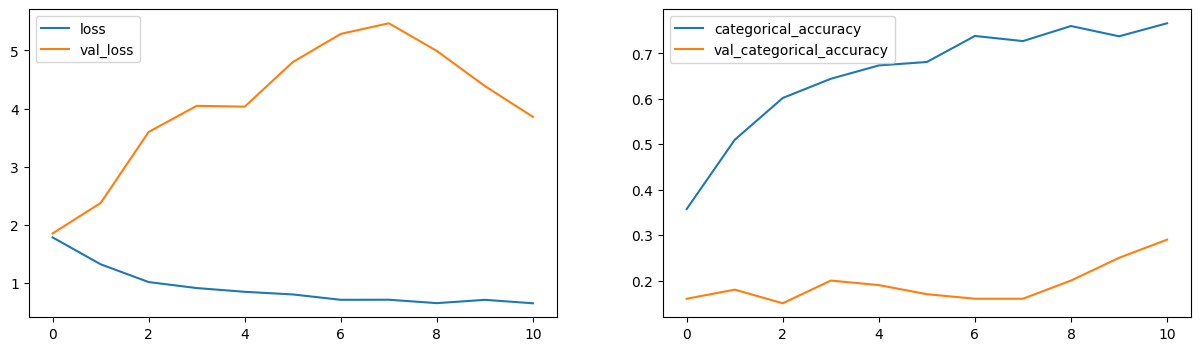

In [ ]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of ~30% which is still low which means the I need to add more training data or have to reduce the model complexity.

## Model 8 - CNN- LSTM Model

In [33]:
class RNNCNN1(ModelBuilder):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=64,image_width=64)
rnn_cnn1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 64, 64, 8)       │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 64, 64, 8)       │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 16, 32, 32, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 16, 32, 32, 32)      │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 16, 32, 32, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 16, 16, 16, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 16, 16, 16, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 16, 16, 16, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 16, 8, 8, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 16, 8, 8, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 16, 8, 8, 128)       │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 16, 4, 4, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 16, 4, 4, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 16, 4, 4, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 16, 2, 2, 256)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 16, 1024)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 999,525 (3.81 MB)

 Trainable params: 998,549 (3.81 MB)

 Non-trainable params: 976 (3.81 KB)

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 999525
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - categorical_accuracy: 0.3263 - loss: 1.5094
Epoch 1: val_loss improved from inf to 1.29587, saving model to model_init_2025-03-1622_59_46.578759/model-00001-1.39896-0.39367-1.29587-0.47000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 87s 836ms/step - categorical_accuracy: 0.3273 - loss: 1.5078 - val_categorical_accuracy: 0.4700 - val_loss: 1.2959 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - categorical_accuracy: 0.4762 - loss: 1.2147
Epoch 2: val_loss improved from 1.29587 to 1.09730, saving model to model_init_2025-03-1622_59_46.578759/model-00002-1.21636-0.49246-1.09730-0.49000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - categorical_accuracy: 0.4765 - loss: 1.2147 - val_categorical_accuracy: 0.4900 - val_loss: 1.0973 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - categorical_accuracy: 0.5092 - loss: 1.1921
Epoch 3: val_loss improved from 1.09730 to 0.97365, saving model to model_init_2025-03-1622_59_46.578759/model-00003-1.10292-0.55204-0.97365-0.59000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - categorical_accuracy: 0.5099 - loss: 1.1908 - val_categorical_accuracy: 0.5900 - val_loss: 0.9736 - learning_rate: 0.0010
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - categorical_accuracy: 0.6134 - loss: 0.9500
Epoch 4: val_loss improved from 0.97365 to 0.86595, saving model to model_init_2025-03-1622_59_46.578759/model-00004-0.95678-0.61388-0.86595-0.69000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - categorical_accuracy: 0.6135 - loss: 0.9501 - val_categorical_accuracy: 0.6900 - val_loss: 0.8659 - learning_rate: 0.0010
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - categorical_accuracy: 0.6369 - loss: 0.9031
Epoch 5: val_loss did not improve from 0.86595
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - categorical_accuracy: 0.6369 - loss: 0.9031 - val_categorical_accuracy: 0.6300 - val_loss: 0.8840 - learning_rate: 0.0010
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - categorical_accuracy: 0.6789 - loss: 0.7757
Epoch 6: val_loss did not improve from 0.86595
67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 734ms/step - categorical_accuracy: 0.6789 - loss: 0.7758 - val_categorical_accuracy: 0.5800 - val_loss: 1.0351 - learning_rate: 0.0010
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - categorical_accuracy: 0.7506 - loss: 0.7188
Epoch 7: val_loss did not improve from 0.86595
67/67 ━━━━━━━━━━━━━━━━━━━━ 47s 716ms/step - categorical_accuracy: 0.7503 

67/67 ━━━━━━━━━━━━━━━━━━━━ 49s 734ms/step - categorical_accuracy: 0.7725 - loss: 0.5599 - val_categorical_accuracy: 0.6500 - val_loss: 0.8259 - learning_rate: 0.0010
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - categorical_accuracy: 0.7528 - loss: 0.6320
Epoch 9: val_loss improved from 0.82590 to 0.74112, saving model to model_init_2025-03-1622_59_46.578759/model-00009-0.66696-0.73605-0.74112-0.70000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - categorical_accuracy: 0.7526 - loss: 0.6325 - val_categorical_accuracy: 0.7000 - val_loss: 0.7411 - learning_rate: 0.0010
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - categorical_accuracy: 0.7699 - loss: 0.5808
Epoch 10: val_loss improved from 0.74112 to 0.68618, saving model to model_init_2025-03-1622_59_46.578759/model-00010-0.61378-0.76923-0.68618-0.71000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 719ms/step - categorical_accuracy: 0.7699 - loss: 0.5813 - val_categorical_accuracy: 0.7100 - val_loss: 0.6862 - learning_rate: 0.0010
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - categorical_accuracy: 0.7940 - loss: 0.5193
Epoch 11: val_loss improved from 0.68618 to 0.66128, saving model to model_init_2025-03-1622_59_46.578759/model-00011-0.51435-0.80317-0.66128-0.71000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 721ms/step - categorical_accuracy: 0.7942 - loss: 0.5192 - val_categorical_accuracy: 0.7100 - val_loss: 0.6613 - learning_rate: 0.0010
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - categorical_accuracy: 0.8794 - loss: 0.3620
Epoch 12: val_loss did not improve from 0.66128
67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - categorical_accuracy: 0.8789 - loss: 0.3629 - val_categorical_accuracy: 0.6800 - val_loss: 0.7525 - learning_rate: 0.0010
Epoch 13/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - categorical_accuracy: 0.8407 - loss: 0.4202
Epoch 13: val_loss did not improve from 0.66128
67/67 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - categorical_accuracy: 0.8403 - loss: 0.4206 - val_categorical_accuracy: 0.7900 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 14/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - categorical_accuracy: 0.8521 - loss: 0.3927
Epoch 14: val_loss did not improve from 0.66128
67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - categorical_accuracy: 0.85

67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - categorical_accuracy: 0.8772 - loss: 0.3412 - val_categorical_accuracy: 0.8100 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 16/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - categorical_accuracy: 0.9156 - loss: 0.2296
Epoch 16: val_loss did not improve from 0.59021
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 723ms/step - categorical_accuracy: 0.9155 - loss: 0.2301 - val_categorical_accuracy: 0.7700 - val_loss: 0.7934 - learning_rate: 0.0010
Epoch 17/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - categorical_accuracy: 0.9100 - loss: 0.2572
Epoch 17: val_loss improved from 0.59021 to 0.38356, saving model to model_init_2025-03-1622_59_46.578759/model-00017-0.28423-0.89367-0.38356-0.87000.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - categorical_accuracy: 0.9097 - loss: 0.2576 - val_categorical_accuracy: 0.8700 - val_loss: 0.3836 - learning_rate: 0.0010
Epoch 18/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - categorical_accuracy: 0.9168 - loss: 0.2375
Epoch 18: val_loss did not improve from 0.38356
67/67 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - categorical_accuracy: 0.9168 - loss: 0.2378 - val_categorical_accuracy: 0.7300 - val_loss: 0.8868 - learning_rate: 0.0010
Epoch 19/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - categorical_accuracy: 0.9315 - loss: 0.1962
Epoch 19: val_loss did not improve from 0.38356
67/67 ━━━━━━━━━━━━━━━━━━━━ 48s 726ms/step - categorical_accuracy: 0.9314 - loss: 0.1965 - val_categorical_accuracy: 0.7000 - val_loss: 1.0342 - learning_rate: 0.0010
Epoch 20/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - categorical_accuracy: 0.9390 - loss: 0.1497
Epoch 20: val_loss did not improve from 0.38356
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 748ms/step - categorical_accuracy: 0

###Resource Exhaustion:

> While trying for CNN-LSTM hybrid combination with layers [16,32,64,128,256], I hit the Resource Exhaustion termination.

```
OOM when allocating tensor with shape[18,40,120,120,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_11_1/time_distributed_2_1/strided_slice_13/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_115070]
```
Hence I have reduced the first input layer from 16 neurons to 8 neurons and thus reducing the parameters I was able to overcome the resource exhaustion and get a better performance with below history details -



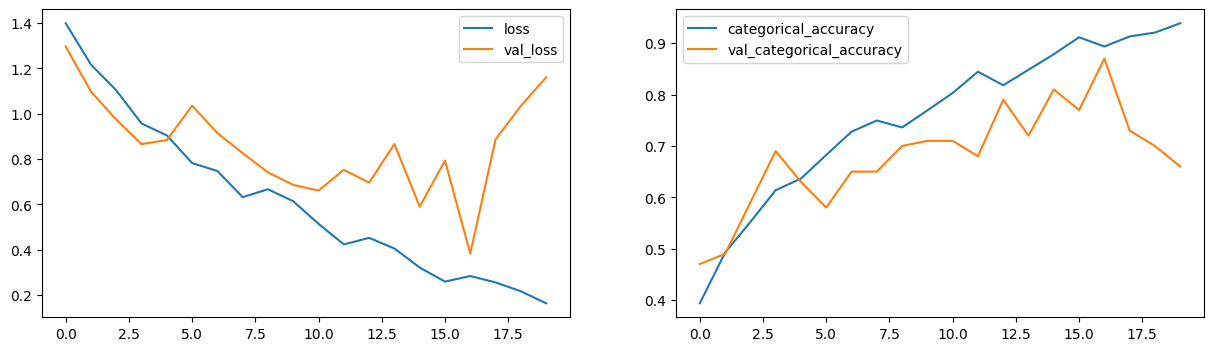

In [ ]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 87% ⚡

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [15]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):

    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs


    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size

            for batch in range(num_batches):
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels

            remaining_seq=len(t)%batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels


    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_labels = np.zeros((seq_len,self.num_classes))

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))


        for folder in range(seq_len):
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
            for idx,item in enumerate(img_idx):
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))


                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0].astype(np.float32))/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1].astype(np.float32))/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2].astype(np.float32))/255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                            (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)

                    cropped=shifted[x0:x1,y0:y1,:]

                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))

                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))

                    #shifted = cv2.warpAffine(image_resized,
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]),
                    #                        (image_resized.shape[1], image_resized.shape[0]))

                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255


            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1


        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])


        return(batch_data,batch_labels)


    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1

        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
        return history


    @abc.abstractmethod
    def define_model(self):
        pass



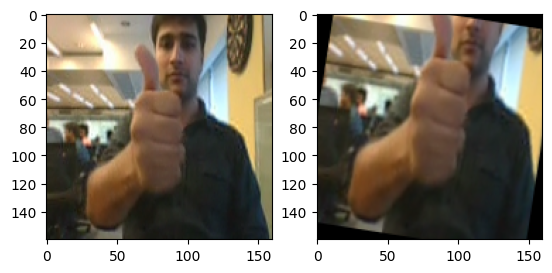

In [ ]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])
axes[1].imshow(batch_data[3,29,:,:,:])

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [ ]:
class ModelConv3D9(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 20, 160, 160, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 20, 160, 160, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 20, 160, 160, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 10, 80, 80, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 10, 80, 80, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10, 80, 80, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 5, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 5, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 5, 40, 40, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 2, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_7 (Conv3D)                    │ (None, 2, 20, 20, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 2, 20, 20, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 2, 20, 20, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 1, 10, 10, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,638,981 (13.88 MB)

 Trainable params: 3,637,477 (13.88 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3185 - loss: 2.2074
Epoch 1: saving model to model_init_2025-03-1700_51_06.818770/model-00001-1.96816-0.36576-1.97396-0.21000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - categorical_accuracy: 0.3199 - loss: 2.2006 - val_categorical_accuracy: 0.2100 - val_loss: 1.9740 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5157 - loss: 1.4548
Epoch 2: saving model to model_init_2025-03-1700_51_06.818770/model-00002-1.43047-0.52489-3.19767-0.22000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - categorical_accuracy: 0.5159 - loss: 1.4541 - val_categorical_accuracy: 0.2200 - val_loss: 3.1977 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5938 - loss: 1.0949
Epoch 3: saving model to model_init_2025-03-1700_51_06.818770/model-00003-1.14536-0.58371-4.66618-0.19000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - categorical_accuracy: 0.5935 - loss: 1.0964 - val_categorical_accuracy: 0.1900 - val_loss: 4.6662 - learning_rate: 2.0000e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6311 - loss: 1.0337
Epoch 4: saving model to model_init_2025-03-1700_51_06.818770/model-00004-1.09980-0.61011-5.61167-0.20000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - categorical_accuracy: 0.6305 - loss: 1.0356 - val_categorical_accuracy: 0.2000 - val_loss: 5.6117 - learning_rate: 2.0000e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6579 - loss: 0.9939
Epoch 5: saving model to model_init_2025-03-1700_51_06.818770/model-00005-0.97755-0.66214-6.26772-0.24000.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - categorical_accuracy: 0.6580 - loss: 0.9935 - val_categorical_accuracy: 0.2400 - val_loss: 6.2677 - learning_rate: 2.0000e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7085 - loss: 0.8242
Epoch 6: saving model to model_init_2025-03-1700_51_06.818770/model-00006-0.84058-0.69910-6.53097-0.30000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - categorical_accuracy: 0.7082 - loss: 0.8247 - val_categorical_accuracy: 0.3000 - val_loss: 6.5310 - learning_rate: 4.0000e-05
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7140 - loss: 0.8018
Epoch 7: saving model to model_init_2025-03-1700_51_06.818770/model-00007-0.80114-0.71644-6.52837-0.26000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - categorical_accuracy: 0.7141 - loss: 0.8018 - val_categorical_accuracy: 0.2600 - val_loss: 6.5284 - learning_rate: 4.0000e-05
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7112 - loss: 0.7691
Epoch 8: saving model to model_init_2025-03-1700_51_06.818770/model-00008-0.76358-0.71192-6.56648-0.26000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - categorical_accuracy: 0.7112 - loss: 0.7690 - val_categorical_accuracy: 0.2600 - val_loss: 6.5665 - learning_rate: 4.0000e-05
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7141 - loss: 0.7587
Epoch 9: saving model to model_init_2025-03-1700_51_06.818770/model-00009-0.78492-0.70965-6.31977-0.27000.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
34/34 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - categorical_accuracy: 0.7140 - loss: 0.7595 - val_categorical_accuracy: 0.2700 - val_loss: 6.3198 - learning_rate: 4.0000e-05
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7451 - loss: 0.7022
Epoch 10: saving model to model_init_2025-03-1700_51_06.818770/model-00010-0.70720-0.74510-5.97621-0.24000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - categorical_accuracy: 0.7451 - loss: 0.7023 - val_categorical_accuracy: 0.2400 - val_loss: 5.9762 - learning_rate: 8.0000e-06
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7516 - loss: 0.6917
Epoch 11: saving model to model_init_2025-03-1700_51_06.818770/model-00011-0.70444-0.75038-5.27224-0.26000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - categorical_accuracy: 0.7516 - loss: 0.6920 - val_categorical_accuracy: 0.2600 - val_loss: 5.2722 - learning_rate: 8.0000e-06
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7452 - loss: 0.6678
Epoch 12: saving model to model_init_2025-03-1700_51_06.818770/model-00012-0.69390-0.73756-5.19918-0.22000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - categorical_accuracy: 0.7450 - loss: 0.6685 - val_categorical_accuracy: 0.2200 - val_loss: 5.1992 - learning_rate: 8.0000e-06
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7519 - loss: 0.6542
Epoch 13: saving model to model_init_2025-03-1700_51_06.818770/model-00013-0.67105-0.74585-4.41684-0.28000.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.5999999959603884e-06.
34/34 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - categorical_accuracy: 0.7518 - loss: 0.6547 - val_categorical_accuracy: 0.2800 - val_loss: 4.4168 - learning_rate: 8.0000e-06
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7417 - loss: 0.6628
Epoch 14: saving model to model_init_2025-03-1700_51_06.818770/model-00014-0.64468-0.75943-3.76878-0.28000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - categorical_accuracy: 0.7422 - loss: 0.6623 - val_categorical_accuracy: 0.2800 - val_loss: 3.7688 - learning_rate: 1.6000e-06
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7323 - loss: 0.7166
Epoch 15: saving model to model_init_2025-03-1700_51_06.818770/model-00015-0.71419-0.73680-2.89769-0.31000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - categorical_accuracy: 0.7324 - loss: 0.7166 - val_categorical_accuracy: 0.3100 - val_loss: 2.8977 - learning_rate: 1.6000e-06
Epoch 16/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7614 - loss: 0.7103
Epoch 16: saving model to model_init_2025-03-1700_51_06.818770/model-00016-0.69999-0.75415-2.44145-0.33000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - categorical_accuracy: 0.7612 - loss: 0.7100 - val_categorical_accuracy: 0.3300 - val_loss: 2.4415 - learning_rate: 1.6000e-06
Epoch 17/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7181 - loss: 0.7436
Epoch 17: saving model to model_init_2025-03-1700_51_06.818770/model-00017-0.71264-0.73831-1.97651-0.43000.h5



Epoch 17: ReduceLROnPlateau reducing learning rate to 3.200000037395512e-07.
34/34 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - categorical_accuracy: 0.7187 - loss: 0.7427 - val_categorical_accuracy: 0.4300 - val_loss: 1.9765 - learning_rate: 1.6000e-06
Epoch 18/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7575 - loss: 0.6539
Epoch 18: saving model to model_init_2025-03-1700_51_06.818770/model-00018-0.70223-0.74434-1.36545-0.55000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - categorical_accuracy: 0.7571 - loss: 0.6552 - val_categorical_accuracy: 0.5500 - val_loss: 1.3654 - learning_rate: 3.2000e-07
Epoch 19/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7679 - loss: 0.6600
Epoch 19: saving model to model_init_2025-03-1700_51_06.818770/model-00019-0.69268-0.75038-1.31438-0.53000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - categorical_accuracy: 0.7674 - loss: 0.6609 - val_categorical_accuracy: 0.5300 - val_loss: 1.3144 - learning_rate: 3.2000e-07
Epoch 20/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7412 - loss: 0.6291
Epoch 20: saving model to model_init_2025-03-1700_51_06.818770/model-00020-0.67090-0.73756-0.82324-0.68000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - categorical_accuracy: 0.7411 - loss: 0.6303 - val_categorical_accuracy: 0.6800 - val_loss: 0.8232 - learning_rate: 3.2000e-07


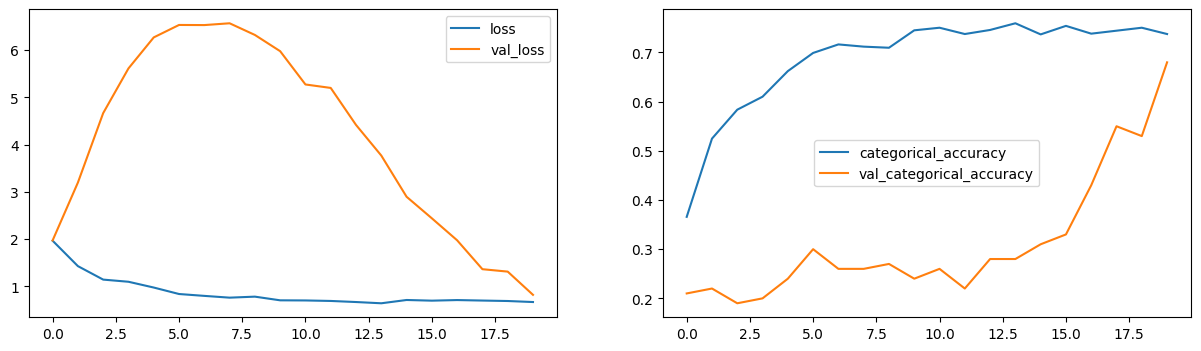

In [ ]:
plot(history_model9)

But with additional augmentation the validation loss reduces. The overall accuracy remains low upto epoch 16 initially and then started increasing with highest validation accuracy of 68%.

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [ ]:
class ModelConv3D10(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)                    │ (None, 16, 120, 120, 16)    │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 8, 60, 60, 32)       │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 2, 15, 15, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,762,613 (6.72 MB)

 Trainable params: 1,761,109 (6.72 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2895 - loss: 2.3113
Epoch 1: saving model to model_init_2025-03-1813_55_23.112190/model-00001-2.10241-0.33183-1.83815-0.21000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - categorical_accuracy: 0.2913 - loss: 2.3026 - val_categorical_accuracy: 0.2100 - val_loss: 1.8381 - learning_rate: 2.0000e-04
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4382 - loss: 1.6366
Epoch 2: saving model to model_init_2025-03-1813_55_23.112190/model-00002-1.54424-0.46833-2.52371-0.22500.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - categorical_accuracy: 0.4394 - loss: 1.6327 - val_categorical_accuracy: 0.2250 - val_loss: 2.5237 - learning_rate: 2.0000e-04
Epoch 3/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.5283 - loss: 1.2980
Epoch 3: saving model to model_init_2025-03-1813_55_23.112190/model-00003-1.26720-0.53620-3.39874-0.24167.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.5289 - loss: 1.2955 - val_categorical_accuracy: 0.2417 - val_loss: 3.3987 - learning_rate: 2.0000e-04
Epoch 4/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.5934 - loss: 1.1747
Epoch 4: saving model to model_init_2025-03-1813_55_23.112190/model-00004-1.14308-0.60332-4.15156-0.22000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.5943 - loss: 1.1721 - val_categorical_accuracy: 0.2200 - val_loss: 4.1516 - learning_rate: 2.0000e-04
Epoch 5/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.5996 - loss: 1.1358
Epoch 5: saving model to model_init_2025-03-1813_55_23.112190/model-00005-1.04083-0.62443-5.31594-0.23000.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - categorical_accuracy: 0.6016 - loss: 1.1278 - val_categorical_accuracy: 0.2300 - val_loss: 5.3159 - learning_rate: 2.0000e-04
Epoch 6/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6642 - loss: 0.9270
Epoch 6: saving model to model_init_2025-03-1813_55_23.112190/model-00006-0.95220-0.65535-6.02434-0.22000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.6635 - loss: 0.9291 - val_categorical_accuracy: 0.2200 - val_loss: 6.0243 - learning_rate: 4.0000e-05
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6358 - loss: 0.9663
Epoch 7: saving model to model_init_2025-03-1813_55_23.112190/model-00007-0.92887-0.66440-6.46100-0.24000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - categorical_accuracy: 0.6370 - loss: 0.9648 - val_categorical_accuracy: 0.2400 - val_loss: 6.4610 - learning_rate: 4.0000e-05
Epoch 8/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6600 - loss: 0.9309
Epoch 8: saving model to model_init_2025-03-1813_55_23.112190/model-00008-0.99315-0.64253-6.34573-0.22000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - categorical_accuracy: 0.6586 - loss: 0.9361 - val_categorical_accuracy: 0.2200 - val_loss: 6.3457 - learning_rate: 4.0000e-05
Epoch 9/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6837 - loss: 0.8860
Epoch 9: saving model to model_init_2025-03-1813_55_23.112190/model-00009-0.92573-0.65535-6.92918-0.23000.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - categorical_accuracy: 0.6814 - loss: 0.8893 - val_categorical_accuracy: 0.2300 - val_loss: 6.9292 - learning_rate: 4.0000e-05
Epoch 10/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6643 - loss: 0.9336
Epoch 10: saving model to model_init_2025-03-1813_55_23.112190/model-00010-0.93042-0.66742-6.77960-0.24000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.6646 - loss: 0.9333 - val_categorical_accuracy: 0.2400 - val_loss: 6.7796 - learning_rate: 8.0000e-06
Epoch 11/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6584 - loss: 0.9105
Epoch 11: saving model to model_init_2025-03-1813_55_23.112190/model-00011-0.89828-0.65913-6.98923-0.24000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - categorical_accuracy: 0.6585 - loss: 0.9100 - val_categorical_accuracy: 0.2400 - val_loss: 6.9892 - learning_rate: 8.0000e-06
Epoch 12/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6851 - loss: 0.8093
Epoch 12: saving model to model_init_2025-03-1813_55_23.112190/model-00012-0.88825-0.67044-6.60613-0.22000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - categorical_accuracy: 0.6838 - loss: 0.8159 - val_categorical_accuracy: 0.2200 - val_loss: 6.6061 - learning_rate: 8.0000e-06
Epoch 13/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6753 - loss: 0.8772
Epoch 13: saving model to model_init_2025-03-1813_55_23.112190/model-00013-0.91590-0.66440-6.62482-0.21000.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.5999999959603884e-06.
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - categorical_accuracy: 0.6744 - loss: 0.8805 - val_categorical_accuracy: 0.2100 - val_loss: 6.6248 - learning_rate: 8.0000e-06
Epoch 14/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6772 - loss: 0.9223
Epoch 14: saving model to model_init_2025-03-1813_55_23.112190/model-00014-0.90156-0.66817-6.17197-0.21000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.6764 - loss: 0.9206 - val_categorical_accuracy: 0.2100 - val_loss: 6.1720 - learning_rate: 1.6000e-06
Epoch 15/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6951 - loss: 0.8499
Epoch 15: saving model to model_init_2025-03-1813_55_23.112190/model-00015-0.86849-0.68326-5.50094-0.28000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.6946 - loss: 0.8506 - val_categorical_accuracy: 0.2800 - val_loss: 5.5009 - learning_rate: 1.6000e-06
Epoch 16/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6731 - loss: 0.8708
Epoch 16: saving model to model_init_2025-03-1813_55_23.112190/model-00016-0.85629-0.66893-5.50550-0.21000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.6729 - loss: 0.8702 - val_categorical_accuracy: 0.2100 - val_loss: 5.5055 - learning_rate: 1.6000e-06
Epoch 17/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6804 - loss: 0.8959
Epoch 17: saving model to model_init_2025-03-1813_55_23.112190/model-00017-0.90936-0.68100-4.89782-0.26000.h5



Epoch 17: ReduceLROnPlateau reducing learning rate to 3.200000037395512e-07.
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.6805 - loss: 0.8970 - val_categorical_accuracy: 0.2600 - val_loss: 4.8978 - learning_rate: 1.6000e-06
Epoch 18/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6776 - loss: 0.9018
Epoch 18: saving model to model_init_2025-03-1813_55_23.112190/model-00018-0.88328-0.68326-4.57527-0.27000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.6781 - loss: 0.9003 - val_categorical_accuracy: 0.2700 - val_loss: 4.5753 - learning_rate: 3.2000e-07
Epoch 19/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6822 - loss: 0.8588
Epoch 19: saving model to model_init_2025-03-1813_55_23.112190/model-00019-0.87020-0.66817-3.80642-0.25000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - categorical_accuracy: 0.6816 - loss: 0.8593 - val_categorical_accuracy: 0.2500 - val_loss: 3.8064 - learning_rate: 3.2000e-07
Epoch 20/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6846 - loss: 0.8722
Epoch 20: saving model to model_init_2025-03-1813_55_23.112190/model-00020-0.89402-0.66968-3.42954-0.26000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - categorical_accuracy: 0.6834 - loss: 0.8740 - val_categorical_accuracy: 0.2600 - val_loss: 3.4295 - learning_rate: 3.2000e-07
Epoch 21/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6889 - loss: 0.8272
Epoch 21: saving model to model_init_2025-03-1813_55_23.112190/model-00021-0.83627-0.68627-2.78590-0.28000.h5



Epoch 21: ReduceLROnPlateau reducing learning rate to 6.399999961104187e-08.
23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - categorical_accuracy: 0.6888 - loss: 0.8276 - val_categorical_accuracy: 0.2800 - val_loss: 2.7859 - learning_rate: 3.2000e-07
Epoch 22/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.7003 - loss: 0.8932
Epoch 22: saving model to model_init_2025-03-1813_55_23.112190/model-00022-0.90574-0.68477-2.55070-0.30000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - categorical_accuracy: 0.6996 - loss: 0.8937 - val_categorical_accuracy: 0.3000 - val_loss: 2.5507 - learning_rate: 6.4000e-08
Epoch 23/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6934 - loss: 0.8337
Epoch 23: saving model to model_init_2025-03-1813_55_23.112190/model-00023-0.86369-0.67572-2.13243-0.36000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.6926 - loss: 0.8350 - val_categorical_accuracy: 0.3600 - val_loss: 2.1324 - learning_rate: 6.4000e-08
Epoch 24/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6768 - loss: 0.8593
Epoch 24: saving model to model_init_2025-03-1813_55_23.112190/model-00024-0.87218-0.68175-1.84266-0.40000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - categorical_accuracy: 0.6770 - loss: 0.8598 - val_categorical_accuracy: 0.4000 - val_loss: 1.8427 - learning_rate: 6.4000e-08
Epoch 25/25
22/23 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - categorical_accuracy: 0.6644 - loss: 0.8966
Epoch 25: saving model to model_init_2025-03-1813_55_23.112190/model-00025-0.90684-0.67044-1.57142-0.44000.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - categorical_accuracy: 0.6649 - loss: 0.8975 - val_categorical_accuracy: 0.4400 - val_loss: 1.5714 - learning_rate: 6.4000e-08


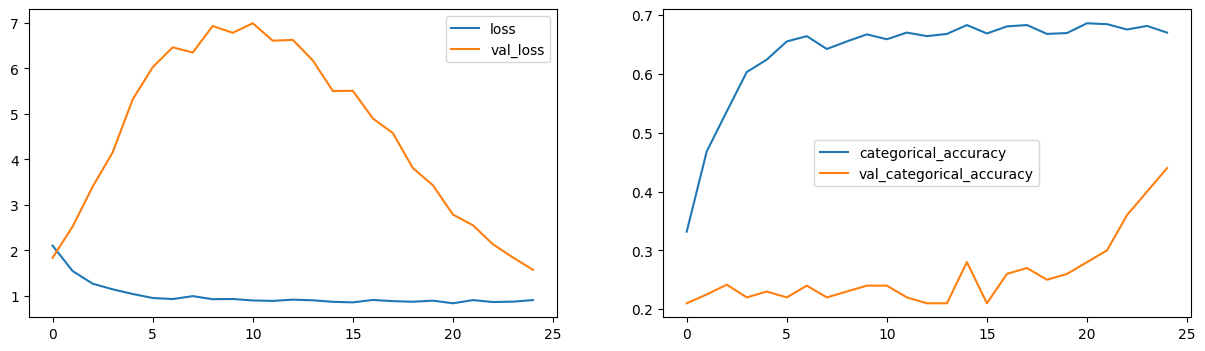

In [ ]:
plot(history_model10)

Not much improvement !

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [18]:
class ModelConv3D11(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))


        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_13 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_14 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_15 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_16 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_17 (Conv3D)                   │ (None, 4, 30, 30, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 4, 30, 30, 64)       │              

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [20]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3162 - loss: 2.1878
Epoch 1: saving model to model_init_2025-03-1815_13_20.192923/model-00001-1.99769-0.35520-28.13269-0.23000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - categorical_accuracy: 0.3173 - loss: 2.1824 - val_categorical_accuracy: 0.2300 - val_loss: 28.1327 - learning_rate: 0.0020
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4266 - loss: 1.6135
Epoch 2: saving model to model_init_2025-03-1815_13_20.192923/model-00002-1.61683-0.40950-2.75795-0.26000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - categorical_accuracy: 0.4261 - loss: 1.6136 - val_categorical_accuracy: 0.2600 - val_loss: 2.7579 - learning_rate: 0.0020
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4833 - loss: 1.3778
Epoch 3: saving model to model_init_2025-03-1815_13_20.192923/model-00003-1.38645-0.49698-1.83241-0.40000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.4837 - loss: 1.3781 - val_categorical_accuracy: 0.4000 - val_loss: 1.8324 - learning_rate: 0.0020
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5480 - loss: 1.2394
Epoch 4: saving model to model_init_2025-03-1815_13_20.192923/model-00004-1.25970-0.55505-3.58005-0.14000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.5482 - loss: 1.2400 - val_categorical_accuracy: 0.1400 - val_loss: 3.5800 - learning_rate: 0.0020
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6003 - loss: 0.9806
Epoch 5: saving model to model_init_2025-03-1815_13_20.192923/model-00005-0.98002-0.61840-1.77684-0.32000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.6009 - loss: 0.9806 - val_categorical_accuracy: 0.3200 - val_loss: 1.7768 - learning_rate: 0.0020
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6348 - loss: 1.0082
Epoch 6: saving model to model_init_2025-03-1815_13_20.192923/model-00006-1.05859-0.61765-4.87188-0.18000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.6343 - loss: 1.0096 - val_categorical_accuracy: 0.1800 - val_loss: 4.8719 - learning_rate: 0.0020
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6592 - loss: 0.9551
Epoch 7: saving model to model_init_2025-03-1815_13_20.192923/model-00007-0.98053-0.64630-2.43834-0.33000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.6588 - loss: 0.9558 - val_categorical_accuracy: 0.3300 - val_loss: 2.4383 - learning_rate: 0.0020
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6812 - loss: 0.8103
Epoch 8: saving model to model_init_2025-03-1815_13_20.192923/model-00008-0.81699-0.68703-1.44464-0.58000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.6814 - loss: 0.8105 - val_categorical_accuracy: 0.5800 - val_loss: 1.4446 - learning_rate: 0.0020
Epoch 9/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7087 - loss: 0.7424
Epoch 9: saving model to model_init_2025-03-1815_13_20.192923/model-00009-0.80858-0.68552-4.23260-0.29000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.7080 - loss: 0.7443 - val_categorical_accuracy: 0.2900 - val_loss: 4.2326 - learning_rate: 0.0020
Epoch 10/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7113 - loss: 0.7796
Epoch 10: saving model to model_init_2025-03-1815_13_20.192923/model-00010-0.79283-0.69910-2.94402-0.27000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.7109 - loss: 0.7800 - val_categorical_accuracy: 0.2700 - val_loss: 2.9440 - learning_rate: 0.0020
Epoch 11/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7138 - loss: 0.7508
Epoch 11: saving model to model_init_2025-03-1815_13_20.192923/model-00011-0.77667-0.71116-2.01525-0.45000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.7138 - loss: 0.7515 - val_categorical_accuracy: 0.4500 - val_loss: 2.0152 - learning_rate: 0.0020
Epoch 12/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7263 - loss: 0.7037
Epoch 12: saving model to model_init_2025-03-1815_13_20.192923/model-00012-0.76119-0.71267-3.44555-0.40000.h5



Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - categorical_accuracy: 0.7259 - loss: 0.7053 - val_categorical_accuracy: 0.4000 - val_loss: 3.4455 - learning_rate: 0.0020
Epoch 13/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7661 - loss: 0.6441
Epoch 13: saving model to model_init_2025-03-1815_13_20.192923/model-00013-0.61656-0.77677-1.14152-0.64000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.7664 - loss: 0.6433 - val_categorical_accuracy: 0.6400 - val_loss: 1.1415 - learning_rate: 4.0000e-04
Epoch 14/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8079 - loss: 0.4983
Epoch 14: saving model to model_init_2025-03-1815_13_20.192923/model-00014-0.51994-0.80090-0.85063-0.72000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - categorical_accuracy: 0.8077 - loss: 0.4989 - val_categorical_accuracy: 0.7200 - val_loss: 0.8506 - learning_rate: 4.0000e-04
Epoch 15/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8155 - loss: 0.4899
Epoch 15: saving model to model_init_2025-03-1815_13_20.192923/model-00015-0.50442-0.80694-0.73677-0.73000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.8152 - loss: 0.4903 - val_categorical_accuracy: 0.7300 - val_loss: 0.7368 - learning_rate: 4.0000e-04
Epoch 16/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8231 - loss: 0.4676
Epoch 16: saving model to model_init_2025-03-1815_13_20.192923/model-00016-0.49216-0.80995-0.76774-0.71000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.8228 - loss: 0.4683 - val_categorical_accuracy: 0.7100 - val_loss: 0.7677 - learning_rate: 4.0000e-04
Epoch 17/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8329 - loss: 0.4643
Epoch 17: saving model to model_init_2025-03-1815_13_20.192923/model-00017-0.47631-0.82353-0.82672-0.69000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.8326 - loss: 0.4646 - val_categorical_accuracy: 0.6900 - val_loss: 0.8267 - learning_rate: 4.0000e-04
Epoch 18/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8185 - loss: 0.4589
Epoch 18: saving model to model_init_2025-03-1815_13_20.192923/model-00018-0.46015-0.82655-0.65308-0.80000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.8187 - loss: 0.4589 - val_categorical_accuracy: 0.8000 - val_loss: 0.6531 - learning_rate: 4.0000e-04
Epoch 19/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8314 - loss: 0.4043
Epoch 19: saving model to model_init_2025-03-1815_13_20.192923/model-00019-0.46937-0.81448-0.66236-0.75000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.8309 - loss: 0.4061 - val_categorical_accuracy: 0.7500 - val_loss: 0.6624 - learning_rate: 4.0000e-04
Epoch 20/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8524 - loss: 0.4122
Epoch 20: saving model to model_init_2025-03-1815_13_20.192923/model-00020-0.42527-0.83560-1.02807-0.73000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.8519 - loss: 0.4125 - val_categorical_accuracy: 0.7300 - val_loss: 1.0281 - learning_rate: 4.0000e-04
Epoch 21/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8479 - loss: 0.3827
Epoch 21: saving model to model_init_2025-03-1815_13_20.192923/model-00021-0.41259-0.84314-0.71937-0.76000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - categorical_accuracy: 0.8478 - loss: 0.3836 - val_categorical_accuracy: 0.7600 - val_loss: 0.7194 - learning_rate: 4.0000e-04
Epoch 22/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8471 - loss: 0.3969
Epoch 22: saving model to model_init_2025-03-1815_13_20.192923/model-00022-0.38682-0.85596-0.55509-0.83000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.8474 - loss: 0.3966 - val_categorical_accuracy: 0.8300 - val_loss: 0.5551 - learning_rate: 4.0000e-04
Epoch 23/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8814 - loss: 0.3325
Epoch 23: saving model to model_init_2025-03-1815_13_20.192923/model-00023-0.33666-0.87783-0.64488-0.77000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.8813 - loss: 0.3326 - val_categorical_accuracy: 0.7700 - val_loss: 0.6449 - learning_rate: 4.0000e-04
Epoch 24/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8850 - loss: 0.3156
Epoch 24: saving model to model_init_2025-03-1815_13_20.192923/model-00024-0.34053-0.87557-0.61822-0.77000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.8848 - loss: 0.3163 - val_categorical_accuracy: 0.7700 - val_loss: 0.6182 - learning_rate: 4.0000e-04
Epoch 25/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9004 - loss: 0.3146
Epoch 25: saving model to model_init_2025-03-1815_13_20.192923/model-00025-0.32690-0.89140-0.61980-0.76000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - categorical_accuracy: 0.9002 - loss: 0.3150 - val_categorical_accuracy: 0.7600 - val_loss: 0.6198 - learning_rate: 4.0000e-04


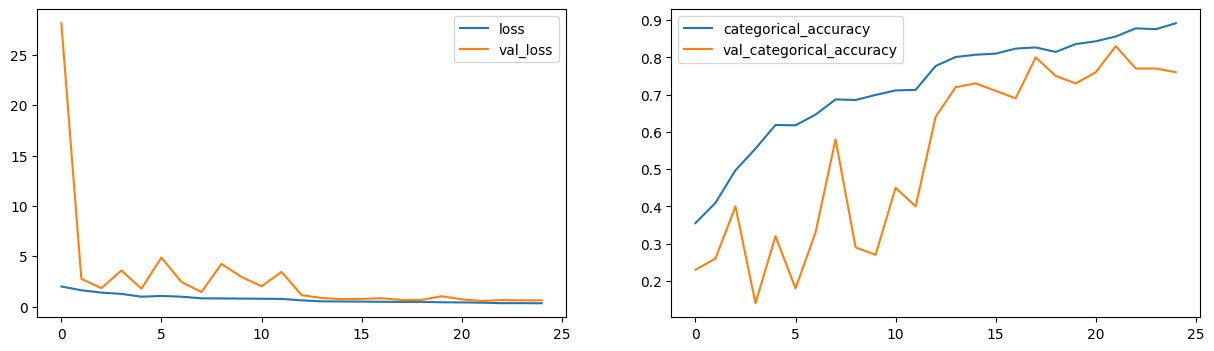

In [21]:
plot(history_model11)

The model performance improved after increasing the learning rate and best validation accuracy obtained at epoch 22 with 83%, good progress !

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [22]:
class ModelConv3D12(ModelBuilderMoreAugmentation):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_20 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_21 (Conv3D)                   │ (None, 16, 120, 120, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_22 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_23 (Conv3D)                   │ (None, 8, 60, 60, 32)       │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_13 (MaxPooling3D)      │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_24 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,556,533 (9.75 MB)

 Trainable params: 2,554,549 (9.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [24]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3420 - loss: 1.9743
Epoch 1: saving model to model_init_2025-03-1815_52_55.914665/model-00001-1.73799-0.37557-21.49290-0.21000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - categorical_accuracy: 0.3429 - loss: 1.9676 - val_categorical_accuracy: 0.2100 - val_loss: 21.4929 - learning_rate: 0.0020
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5403 - loss: 1.1885
Epoch 2: saving model to model_init_2025-03-1815_52_55.914665/model-00002-1.24741-0.52112-8.19003-0.15000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.5398 - loss: 1.1902 - val_categorical_accuracy: 0.1500 - val_loss: 8.1900 - learning_rate: 0.0020
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5543 - loss: 1.1931
Epoch 3: saving model to model_init_2025-03-1815_52_55.914665/model-00003-1.16981-0.55430-3.30448-0.15000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - categorical_accuracy: 0.5543 - loss: 1.1924 - val_categorical_accuracy: 0.1500 - val_loss: 3.3045 - learning_rate: 0.0020
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5841 - loss: 1.0628
Epoch 4: saving model to model_init_2025-03-1815_52_55.914665/model-00004-1.02084-0.60860-3.20614-0.19000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - categorical_accuracy: 0.5848 - loss: 1.0616 - val_categorical_accuracy: 0.1900 - val_loss: 3.2061 - learning_rate: 0.0020
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6190 - loss: 0.9832
Epoch 5: saving model to model_init_2025-03-1815_52_55.914665/model-00005-0.95803-0.62745-2.40492-0.32000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.6193 - loss: 0.9824 - val_categorical_accuracy: 0.3200 - val_loss: 2.4049 - learning_rate: 0.0020
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6499 - loss: 0.8799
Epoch 6: saving model to model_init_2025-03-1815_52_55.914665/model-00006-0.95029-0.61237-3.15620-0.34000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.6488 - loss: 0.8819 - val_categorical_accuracy: 0.3400 - val_loss: 3.1562 - learning_rate: 0.0020
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6699 - loss: 0.8517
Epoch 7: saving model to model_init_2025-03-1815_52_55.914665/model-00007-0.86011-0.67949-2.59328-0.34000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.6701 - loss: 0.8519 - val_categorical_accuracy: 0.3400 - val_loss: 2.5933 - learning_rate: 0.0020
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6938 - loss: 0.7886
Epoch 8: saving model to model_init_2025-03-1815_52_55.914665/model-00008-0.80986-0.68929-2.56331-0.39000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.6937 - loss: 0.7892 - val_categorical_accuracy: 0.3900 - val_loss: 2.5633 - learning_rate: 0.0020
Epoch 9/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7433 - loss: 0.6561
Epoch 9: saving model to model_init_2025-03-1815_52_55.914665/model-00009-0.67335-0.74057-2.75930-0.37000.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.7432 - loss: 0.6566 - val_categorical_accuracy: 0.3700 - val_loss: 2.7593 - learning_rate: 0.0020
Epoch 10/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7828 - loss: 0.5737
Epoch 10: saving model to model_init_2025-03-1815_52_55.914665/model-00010-0.58956-0.77300-2.21404-0.38000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.7825 - loss: 0.5742 - val_categorical_accuracy: 0.3800 - val_loss: 2.2140 - learning_rate: 4.0000e-04
Epoch 11/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8435 - loss: 0.4255
Epoch 11: saving model to model_init_2025-03-1815_52_55.914665/model-00011-0.46088-0.82278-2.42699-0.32000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.8429 - loss: 0.4265 - val_categorical_accuracy: 0.3200 - val_loss: 2.4270 - learning_rate: 4.0000e-04
Epoch 12/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7864 - loss: 0.5279
Epoch 12: saving model to model_init_2025-03-1815_52_55.914665/model-00012-0.50384-0.79789-2.04480-0.33000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - categorical_accuracy: 0.7867 - loss: 0.5272 - val_categorical_accuracy: 0.3300 - val_loss: 2.0448 - learning_rate: 4.0000e-04
Epoch 13/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8444 - loss: 0.4115
Epoch 13: saving model to model_init_2025-03-1815_52_55.914665/model-00013-0.40870-0.84917-1.54502-0.48000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.8445 - loss: 0.4114 - val_categorical_accuracy: 0.4800 - val_loss: 1.5450 - learning_rate: 4.0000e-04
Epoch 14/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8599 - loss: 0.3631
Epoch 14: saving model to model_init_2025-03-1815_52_55.914665/model-00014-0.39370-0.84766-1.28503-0.51000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - categorical_accuracy: 0.8595 - loss: 0.3640 - val_categorical_accuracy: 0.5100 - val_loss: 1.2850 - learning_rate: 4.0000e-04
Epoch 15/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8542 - loss: 0.3916
Epoch 15: saving model to model_init_2025-03-1815_52_55.914665/model-00015-0.39486-0.85520-1.27436-0.54000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - categorical_accuracy: 0.8542 - loss: 0.3917 - val_categorical_accuracy: 0.5400 - val_loss: 1.2744 - learning_rate: 4.0000e-04
Epoch 16/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8597 - loss: 0.3692
Epoch 16: saving model to model_init_2025-03-1815_52_55.914665/model-00016-0.40569-0.84389-0.94397-0.68000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - categorical_accuracy: 0.8593 - loss: 0.3702 - val_categorical_accuracy: 0.6800 - val_loss: 0.9440 - learning_rate: 4.0000e-04
Epoch 17/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8833 - loss: 0.3104
Epoch 17: saving model to model_init_2025-03-1815_52_55.914665/model-00017-0.35203-0.87029-0.88776-0.67000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - categorical_accuracy: 0.8829 - loss: 0.3116 - val_categorical_accuracy: 0.6700 - val_loss: 0.8878 - learning_rate: 4.0000e-04
Epoch 18/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8578 - loss: 0.3803
Epoch 18: saving model to model_init_2025-03-1815_52_55.914665/model-00018-0.41000-0.85219-1.15345-0.64000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - categorical_accuracy: 0.8576 - loss: 0.3811 - val_categorical_accuracy: 0.6400 - val_loss: 1.1535 - learning_rate: 4.0000e-04
Epoch 19/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8861 - loss: 0.3087
Epoch 19: saving model to model_init_2025-03-1815_52_55.914665/model-00019-0.31503-0.88914-0.68811-0.74000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.8861 - loss: 0.3089 - val_categorical_accuracy: 0.7400 - val_loss: 0.6881 - learning_rate: 4.0000e-04
Epoch 20/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8835 - loss: 0.3321
Epoch 20: saving model to model_init_2025-03-1815_52_55.914665/model-00020-0.33759-0.88009-0.84339-0.66000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - categorical_accuracy: 0.8834 - loss: 0.3322 - val_categorical_accuracy: 0.6600 - val_loss: 0.8434 - learning_rate: 4.0000e-04
Epoch 21/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8784 - loss: 0.3343
Epoch 21: saving model to model_init_2025-03-1815_52_55.914665/model-00021-0.35684-0.86199-0.79957-0.74000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - categorical_accuracy: 0.8779 - loss: 0.3350 - val_categorical_accuracy: 0.7400 - val_loss: 0.7996 - learning_rate: 4.0000e-04
Epoch 22/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8762 - loss: 0.3358
Epoch 22: saving model to model_init_2025-03-1815_52_55.914665/model-00022-0.34843-0.86350-0.98665-0.70000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.8758 - loss: 0.3362 - val_categorical_accuracy: 0.7000 - val_loss: 0.9867 - learning_rate: 4.0000e-04
Epoch 23/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8885 - loss: 0.3030
Epoch 23: saving model to model_init_2025-03-1815_52_55.914665/model-00023-0.29523-0.89442-0.71789-0.76000.h5



Epoch 23: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.8886 - loss: 0.3027 - val_categorical_accuracy: 0.7600 - val_loss: 0.7179 - learning_rate: 4.0000e-04
Epoch 24/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9095 - loss: 0.2440
Epoch 24: saving model to model_init_2025-03-1815_52_55.914665/model-00024-0.27117-0.89970-0.70097-0.78000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.9093 - loss: 0.2447 - val_categorical_accuracy: 0.7800 - val_loss: 0.7010 - learning_rate: 8.0000e-05
Epoch 25/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9356 - loss: 0.2143
Epoch 25: saving model to model_init_2025-03-1815_52_55.914665/model-00025-0.23946-0.92006-0.80731-0.73000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.9351 - loss: 0.2150 - val_categorical_accuracy: 0.7300 - val_loss: 0.8073 - learning_rate: 8.0000e-05


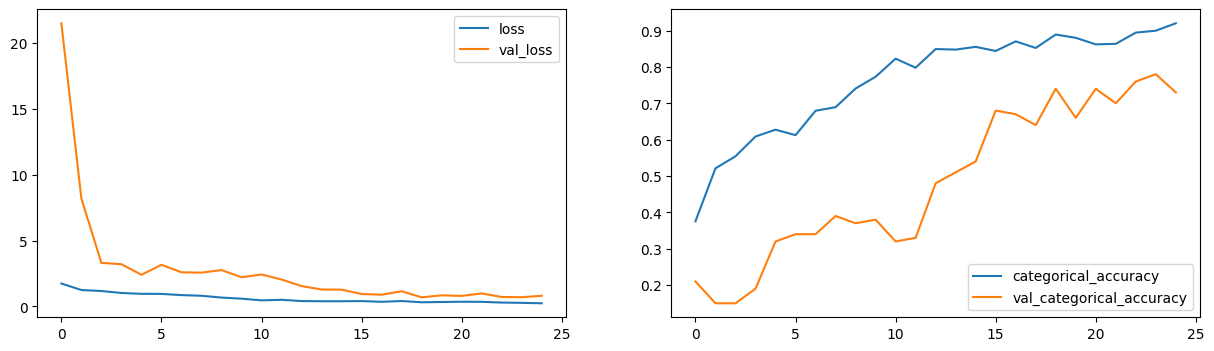

In [25]:
plot(history_model12)

Model is still overfitting though loss has reduced and the best validation accuracy obtained is 78%

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [26]:
class ModelConv3D13(ModelBuilderMoreAugmentation):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_28 (Conv3D)                   │ (None, 16, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_28 (Activation)           │ (None, 16, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 16, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_16 (MaxPooling3D)      │ (None, 8, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_29 (Conv3D)                   │ (None, 8, 50, 50, 32)       │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 8, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 8, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_17 (MaxPooling3D)      │ (None, 4, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_30 (Conv3D)                   │ (None, 4, 25, 25, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 4, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 4, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_18 (MaxPooling3D)      │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_31 (Conv3D)                   │ (None, 2, 12, 12, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 2, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 2, 12, 12, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_19 (MaxPooling3D)      │ (None, 1, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 696,645 (2.66 MB)

 Trainable params: 695,653 (2.65 MB)

 Non-trainable params: 992 (3.88 KB)

In [28]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3645 - loss: 1.7127
Epoch 1: saving model to model_init_2025-03-1816_29_10.108838/model-00001-1.47792-0.44344-2.25588-0.20000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.3668 - loss: 1.7060 - val_categorical_accuracy: 0.2000 - val_loss: 2.2559 - learning_rate: 0.0020
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5956 - loss: 1.0640
Epoch 2: saving model to model_init_2025-03-1816_29_10.108838/model-00002-1.02535-0.61086-5.21571-0.20000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.5960 - loss: 1.0629 - val_categorical_accuracy: 0.2000 - val_loss: 5.2157 - learning_rate: 0.0020
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6779 - loss: 0.7872
Epoch 3: saving model to model_init_2025-03-1816_29_10.108838/model-00003-0.81531-0.69005-6.92036-0.22000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.6783 - loss: 0.7880 - val_categorical_accuracy: 0.2200 - val_loss: 6.9204 - learning_rate: 0.0020
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7368 - loss: 0.7250
Epoch 4: saving model to model_init_2025-03-1816_29_10.108838/model-00004-0.77812-0.70739-8.89277-0.17000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - categorical_accuracy: 0.7360 - loss: 0.7265 - val_categorical_accuracy: 0.1700 - val_loss: 8.8928 - learning_rate: 0.0020
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7613 - loss: 0.6535
Epoch 5: saving model to model_init_2025-03-1816_29_10.108838/model-00005-0.68457-0.74057-8.61521-0.23000.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.7607 - loss: 0.6544 - val_categorical_accuracy: 0.2300 - val_loss: 8.6152 - learning_rate: 0.0020
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7795 - loss: 0.5885
Epoch 6: saving model to model_init_2025-03-1816_29_10.108838/model-00006-0.56331-0.78582-7.63609-0.20000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.7797 - loss: 0.5877 - val_categorical_accuracy: 0.2000 - val_loss: 7.6361 - learning_rate: 4.0000e-04
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8509 - loss: 0.4014
Epoch 7: saving model to model_init_2025-03-1816_29_10.108838/model-00007-0.42789-0.84314-7.05513-0.18000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.8507 - loss: 0.4021 - val_categorical_accuracy: 0.1800 - val_loss: 7.0551 - learning_rate: 4.0000e-04
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8277 - loss: 0.4388
Epoch 8: saving model to model_init_2025-03-1816_29_10.108838/model-00008-0.42179-0.83710-6.49546-0.21000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.8279 - loss: 0.4383 - val_categorical_accuracy: 0.2100 - val_loss: 6.4955 - learning_rate: 4.0000e-04
Epoch 9/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8552 - loss: 0.3944
Epoch 9: saving model to model_init_2025-03-1816_29_10.108838/model-00009-0.37886-0.86199-6.30127-0.22000.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 8.000000379979611e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.8554 - loss: 0.3940 - val_categorical_accuracy: 0.2200 - val_loss: 6.3013 - learning_rate: 4.0000e-04
Epoch 10/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8529 - loss: 0.4061
Epoch 10: saving model to model_init_2025-03-1816_29_10.108838/model-00010-0.37982-0.86275-6.02509-0.24000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.8532 - loss: 0.4054 - val_categorical_accuracy: 0.2400 - val_loss: 6.0251 - learning_rate: 8.0000e-05
Epoch 11/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8723 - loss: 0.3478
Epoch 11: saving model to model_init_2025-03-1816_29_10.108838/model-00011-0.35943-0.87557-5.45886-0.24000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.8724 - loss: 0.3481 - val_categorical_accuracy: 0.2400 - val_loss: 5.4589 - learning_rate: 8.0000e-05
Epoch 12/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8843 - loss: 0.3410
Epoch 12: saving model to model_init_2025-03-1816_29_10.108838/model-00012-0.31256-0.89291-4.85841-0.24000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - categorical_accuracy: 0.8846 - loss: 0.3402 - val_categorical_accuracy: 0.2400 - val_loss: 4.8584 - learning_rate: 8.0000e-05
Epoch 13/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8783 - loss: 0.3356
Epoch 13: saving model to model_init_2025-03-1816_29_10.108838/model-00013-0.33469-0.87858-3.91069-0.27000.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.6000001050997525e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - categorical_accuracy: 0.8783 - loss: 0.3356 - val_categorical_accuracy: 0.2700 - val_loss: 3.9107 - learning_rate: 8.0000e-05
Epoch 14/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9021 - loss: 0.2860
Epoch 14: saving model to model_init_2025-03-1816_29_10.108838/model-00014-0.27797-0.90196-3.35675-0.28000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.9021 - loss: 0.2857 - val_categorical_accuracy: 0.2800 - val_loss: 3.3568 - learning_rate: 1.6000e-05
Epoch 15/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9003 - loss: 0.2941
Epoch 15: saving model to model_init_2025-03-1816_29_10.108838/model-00015-0.33094-0.88386-2.56708-0.34000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - categorical_accuracy: 0.8999 - loss: 0.2952 - val_categorical_accuracy: 0.3400 - val_loss: 2.5671 - learning_rate: 1.6000e-05
Epoch 16/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8936 - loss: 0.2930
Epoch 16: saving model to model_init_2025-03-1816_29_10.108838/model-00016-0.30185-0.89517-2.13991-0.44000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.8936 - loss: 0.2932 - val_categorical_accuracy: 0.4400 - val_loss: 2.1399 - learning_rate: 1.6000e-05
Epoch 17/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9065 - loss: 0.2731
Epoch 17: saving model to model_init_2025-03-1816_29_10.108838/model-00017-0.29104-0.90121-1.73551-0.45000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.9064 - loss: 0.2736 - val_categorical_accuracy: 0.4500 - val_loss: 1.7355 - learning_rate: 1.6000e-05
Epoch 18/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9013 - loss: 0.2842
Epoch 18: saving model to model_init_2025-03-1816_29_10.108838/model-00018-0.29508-0.89140-1.32548-0.47000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.9010 - loss: 0.2845 - val_categorical_accuracy: 0.4700 - val_loss: 1.3255 - learning_rate: 1.6000e-05
Epoch 19/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.8730 - loss: 0.3228
Epoch 19: saving model to model_init_2025-03-1816_29_10.108838/model-00019-0.29422-0.89216-0.87903-0.67000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.8741 - loss: 0.3212 - val_categorical_accuracy: 0.6700 - val_loss: 0.8790 - learning_rate: 1.6000e-05
Epoch 20/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.8903 - loss: 0.3152
Epoch 20: saving model to model_init_2025-03-1816_29_10.108838/model-00020-0.29132-0.90422-0.86968-0.64000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.8911 - loss: 0.3138 - val_categorical_accuracy: 0.6400 - val_loss: 0.8697 - learning_rate: 1.6000e-05
Epoch 21/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9120 - loss: 0.2755
Epoch 21: saving model to model_init_2025-03-1816_29_10.108838/model-00021-0.28746-0.90121-0.87184-0.73000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - categorical_accuracy: 0.9117 - loss: 0.2758 - val_categorical_accuracy: 0.7300 - val_loss: 0.8718 - learning_rate: 1.6000e-05
Epoch 22/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9035 - loss: 0.2930
Epoch 22: saving model to model_init_2025-03-1816_29_10.108838/model-00022-0.31077-0.89442-0.65219-0.81000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - categorical_accuracy: 0.9032 - loss: 0.2936 - val_categorical_accuracy: 0.8100 - val_loss: 0.6522 - learning_rate: 1.6000e-05
Epoch 23/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9025 - loss: 0.2934
Epoch 23: saving model to model_init_2025-03-1816_29_10.108838/model-00023-0.30513-0.89744-0.84993-0.78000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - categorical_accuracy: 0.9024 - loss: 0.2938 - val_categorical_accuracy: 0.7800 - val_loss: 0.8499 - learning_rate: 1.6000e-05
Epoch 24/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.8920 - loss: 0.3002
Epoch 24: saving model to model_init_2025-03-1816_29_10.108838/model-00024-0.29948-0.88612-0.77450-0.77000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - categorical_accuracy: 0.8916 - loss: 0.3001 - val_categorical_accuracy: 0.7700 - val_loss: 0.7745 - learning_rate: 1.6000e-05
Epoch 25/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8985 - loss: 0.2860
Epoch 25: saving model to model_init_2025-03-1816_29_10.108838/model-00025-0.28817-0.89517-0.84244-0.76000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.8984 - loss: 0.2860 - val_categorical_accuracy: 0.7600 - val_loss: 0.8424 - learning_rate: 1.6000e-05


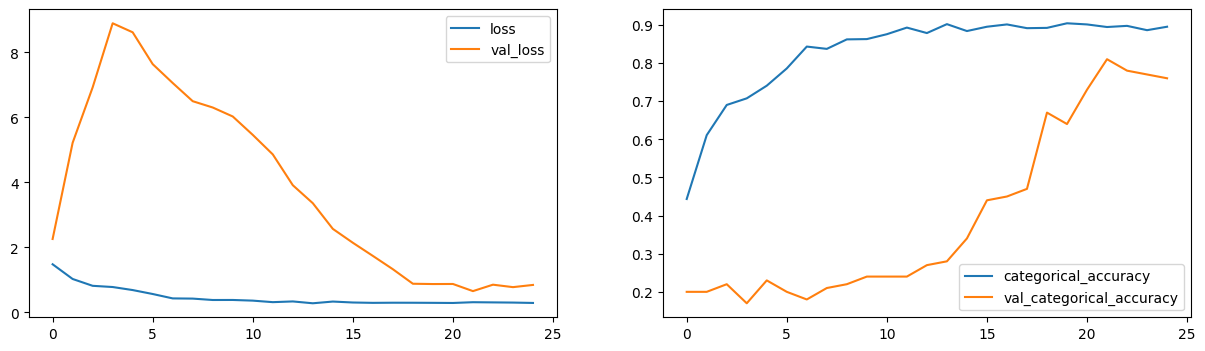

In [29]:
plot(history_model13)

Model overfits and model started to improve only after epoch 19 achieved highest validation accuracy of 81% (epoch 22 and then dropped.

## Model 14 with Augmentation
###  Reducing network parameters again - Similar to model 7

In [ ]:
class ModelConv3D14(ModelBuilderMoreAugmentation):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)                    │ (None, 16, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 8, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_9 (Conv3D)                    │ (None, 8, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 8, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 8, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 4, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 4, 30, 30, 64)       │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 4, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 4, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 2, 15, 15, 128)      │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 2, 15, 15, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2, 15, 15, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 1, 7, 7, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 504,709 (1.93 MB)

 Trainable params: 503,973 (1.92 MB)

 Non-trainable params: 736 (2.88 KB)

In [ ]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2719 - loss: 1.8973
Epoch 1: saving model to model_init_2025-03-1701_35_09.710691/model-00001-1.70805-0.34087-1.91635-0.22000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - categorical_accuracy: 0.2739 - loss: 1.8919 - val_categorical_accuracy: 0.2200 - val_loss: 1.9164 - learning_rate: 2.0000e-04
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4985 - loss: 1.2763
Epoch 2: saving model to model_init_2025-03-1701_35_09.710691/model-00002-1.24181-0.51207-2.20491-0.22000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.4989 - loss: 1.2753 - val_categorical_accuracy: 0.2200 - val_loss: 2.2049 - learning_rate: 2.0000e-04
Epoch 3/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.5602 - loss: 1.0503
Epoch 3: saving model to model_init_2025-03-1701_35_09.710691/model-00003-1.09512-0.55505-2.72579-0.15000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - categorical_accuracy: 0.5599 - loss: 1.0528 - val_categorical_accuracy: 0.1500 - val_loss: 2.7258 - learning_rate: 2.0000e-04
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6020 - loss: 1.0181
Epoch 4: saving model to model_init_2025-03-1701_35_09.710691/model-00004-0.98363-0.60935-3.27524-0.26000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - categorical_accuracy: 0.6022 - loss: 1.0172 - val_categorical_accuracy: 0.2600 - val_loss: 3.2752 - learning_rate: 2.0000e-04
Epoch 5/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.6494 - loss: 0.8782
Epoch 5: saving model to model_init_2025-03-1701_35_09.710691/model-00005-0.89623-0.65008-3.81782-0.31000.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - categorical_accuracy: 0.6495 - loss: 0.8792 - val_categorical_accuracy: 0.3100 - val_loss: 3.8178 - learning_rate: 2.0000e-04
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6879 - loss: 0.8046
Epoch 6: saving model to model_init_2025-03-1701_35_09.710691/model-00006-0.81080-0.69155-4.37941-0.26000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.6880 - loss: 0.8048 - val_categorical_accuracy: 0.2600 - val_loss: 4.3794 - learning_rate: 4.0000e-05
Epoch 7/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - categorical_accuracy: 0.6972 - loss: 0.7643
Epoch 7: saving model to model_init_2025-03-1701_35_09.710691/model-00007-0.77055-0.70437-5.01359-0.28000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - categorical_accuracy: 0.6976 - loss: 0.7646 - val_categorical_accuracy: 0.2800 - val_loss: 5.0136 - learning_rate: 4.0000e-05
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6916 - loss: 0.8287
Epoch 8: saving model to model_init_2025-03-1701_35_09.710691/model-00008-0.79340-0.69532-5.32127-0.27000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - categorical_accuracy: 0.6917 - loss: 0.8277 - val_categorical_accuracy: 0.2700 - val_loss: 5.3213 - learning_rate: 4.0000e-05
Epoch 9/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7498 - loss: 0.6873
Epoch 9: saving model to model_init_2025-03-1701_35_09.710691/model-00009-0.71480-0.72851-4.94143-0.27000.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
34/34 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - categorical_accuracy: 0.7491 - loss: 0.6881 - val_categorical_accuracy: 0.2700 - val_loss: 4.9414 - learning_rate: 4.0000e-05
Epoch 10/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7355 - loss: 0.6838
Epoch 10: saving model to model_init_2025-03-1701_35_09.710691/model-00010-0.67108-0.74510-4.13125-0.29000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.7358 - loss: 0.6834 - val_categorical_accuracy: 0.2900 - val_loss: 4.1313 - learning_rate: 8.0000e-06
Epoch 11/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7408 - loss: 0.7262
Epoch 11: saving model to model_init_2025-03-1701_35_09.710691/model-00011-0.72652-0.72926-3.13762-0.32000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - categorical_accuracy: 0.7405 - loss: 0.7262 - val_categorical_accuracy: 0.3200 - val_loss: 3.1376 - learning_rate: 8.0000e-06
Epoch 12/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7271 - loss: 0.7027
Epoch 12: saving model to model_init_2025-03-1701_35_09.710691/model-00012-0.70494-0.73152-2.57775-0.29000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - categorical_accuracy: 0.7272 - loss: 0.7028 - val_categorical_accuracy: 0.2900 - val_loss: 2.5777 - learning_rate: 8.0000e-06
Epoch 13/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7238 - loss: 0.7039
Epoch 13: saving model to model_init_2025-03-1701_35_09.710691/model-00013-0.69781-0.73002-2.14452-0.34000.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.5999999959603884e-06.
34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - categorical_accuracy: 0.7240 - loss: 0.7037 - val_categorical_accuracy: 0.3400 - val_loss: 2.1445 - learning_rate: 8.0000e-06
Epoch 14/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7451 - loss: 0.7176
Epoch 14: saving model to model_init_2025-03-1701_35_09.710691/model-00014-0.74154-0.73303-1.68977-0.38000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - categorical_accuracy: 0.7447 - loss: 0.7183 - val_categorical_accuracy: 0.3800 - val_loss: 1.6898 - learning_rate: 1.6000e-06
Epoch 15/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7125 - loss: 0.7298
Epoch 15: saving model to model_init_2025-03-1701_35_09.710691/model-00015-0.71446-0.72624-1.18638-0.59000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - categorical_accuracy: 0.7129 - loss: 0.7293 - val_categorical_accuracy: 0.5900 - val_loss: 1.1864 - learning_rate: 1.6000e-06
Epoch 16/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7267 - loss: 0.7119
Epoch 16: saving model to model_init_2025-03-1701_35_09.710691/model-00016-0.69722-0.72323-1.14770-0.57000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - categorical_accuracy: 0.7266 - loss: 0.7115 - val_categorical_accuracy: 0.5700 - val_loss: 1.1477 - learning_rate: 1.6000e-06
Epoch 17/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.6911 - loss: 0.7729
Epoch 17: saving model to model_init_2025-03-1701_35_09.710691/model-00017-0.72423-0.72323-1.00864-0.66000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.6929 - loss: 0.7702 - val_categorical_accuracy: 0.6600 - val_loss: 1.0086 - learning_rate: 1.6000e-06
Epoch 18/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7507 - loss: 0.6574
Epoch 18: saving model to model_init_2025-03-1701_35_09.710691/model-00018-0.66755-0.75867-0.85925-0.74000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.7509 - loss: 0.6577 - val_categorical_accuracy: 0.7400 - val_loss: 0.8593 - learning_rate: 1.6000e-06
Epoch 19/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.7388 - loss: 0.6712
Epoch 19: saving model to model_init_2025-03-1701_35_09.710691/model-00019-0.68767-0.74133-0.79922-0.72000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.7390 - loss: 0.6721 - val_categorical_accuracy: 0.7200 - val_loss: 0.7992 - learning_rate: 1.6000e-06
Epoch 20/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.7618 - loss: 0.6634
Epoch 20: saving model to model_init_2025-03-1701_35_09.710691/model-00020-0.71003-0.74359-0.79440-0.72000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - categorical_accuracy: 0.7607 - loss: 0.6661 - val_categorical_accuracy: 0.7200 - val_loss: 0.7944 - learning_rate: 1.6000e-06
Epoch 21/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7546 - loss: 0.6908
Epoch 21: saving model to model_init_2025-03-1701_35_09.710691/model-00021-0.72499-0.73906-0.76604-0.70000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.7541 - loss: 0.6918 - val_categorical_accuracy: 0.7000 - val_loss: 0.7660 - learning_rate: 1.6000e-06
Epoch 22/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7277 - loss: 0.7243
Epoch 22: saving model to model_init_2025-03-1701_35_09.710691/model-00022-0.72453-0.72474-0.80369-0.69000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - categorical_accuracy: 0.7276 - loss: 0.7243 - val_categorical_accuracy: 0.6900 - val_loss: 0.8037 - learning_rate: 1.6000e-06
Epoch 23/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7172 - loss: 0.7437
Epoch 23: saving model to model_init_2025-03-1701_35_09.710691/model-00023-0.72645-0.72323-0.66772-0.76000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.7173 - loss: 0.7432 - val_categorical_accuracy: 0.7600 - val_loss: 0.6677 - learning_rate: 1.6000e-06
Epoch 24/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.7354 - loss: 0.6884
Epoch 24: saving model to model_init_2025-03-1701_35_09.710691/model-00024-0.68582-0.73906-0.83225-0.68000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.7356 - loss: 0.6882 - val_categorical_accuracy: 0.6800 - val_loss: 0.8323 - learning_rate: 1.6000e-06
Epoch 25/25
33/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - categorical_accuracy: 0.7538 - loss: 0.6846
Epoch 25: saving model to model_init_2025-03-1701_35_09.710691/model-00025-0.67843-0.75943-0.74480-0.69000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - categorical_accuracy: 0.7541 - loss: 0.6843 - val_categorical_accuracy: 0.6900 - val_loss: 0.7448 - learning_rate: 1.6000e-06


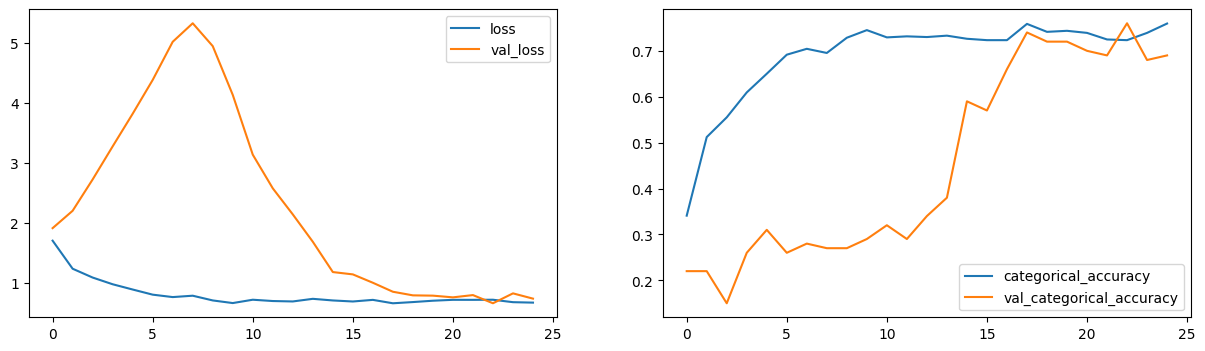

In [ ]:
plot(history_model14)

Model has not been very stable and started fluctuating starting epoch 14

## Model 15 with Augmentation
### CNN with GRU - Similar to Model 8

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(8, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))


        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 18, 120, 120, 8)     │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 18, 120, 120, 8)     │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 18, 60, 60, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 18, 60, 60, 32)      │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 18, 60, 60, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 18, 30, 30, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 18, 30, 30, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 18, 30, 30, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 18, 15, 15, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 18, 15, 15, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 18, 15, 15, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 18, 7, 7, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 18, 6272)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │       2,458,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,571,365 (9.81 MB)

 Trainable params: 2,570,901 (9.81 MB)

 Non-trainable params: 464 (1.81 KB)

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2571365
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.2701 - loss: 1.6588
Epoch 1: saving model to model_init_2025-03-1708_37_38.304798/model-00001-1.51387-0.34012-1.07109-0.65000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - categorical_accuracy: 0.2721 - loss: 1.6546 - val_categorical_accuracy: 0.6500 - val_loss: 1.0711 - learning_rate: 2.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5680 - loss: 1.1185
Epoch 2: saving model to model_init_2025-03-1708_37_38.304798/model-00002-1.08047-0.57391-0.97584-0.61000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.5682 - loss: 1.1174 - val_categorical_accuracy: 0.6100 - val_loss: 0.9758 - learning_rate: 2.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6700 - loss: 0.8731
Epoch 3: saving model to model_init_2025-03-1708_37_38.304798/model-00003-0.87208-0.67421-0.85145-0.73000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - categorical_accuracy: 0.6701 - loss: 0.8731 - val_categorical_accuracy: 0.7300 - val_loss: 0.8514 - learning_rate: 2.0000e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7349 - loss: 0.6970
Epoch 4: saving model to model_init_2025-03-1708_37_38.304798/model-00004-0.73267-0.72097-0.87413-0.65000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - categorical_accuracy: 0.7345 - loss: 0.6980 - val_categorical_accuracy: 0.6500 - val_loss: 0.8741 - learning_rate: 2.0000e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7976 - loss: 0.6040
Epoch 5: saving model to model_init_2025-03-1708_37_38.304798/model-00005-0.59558-0.78884-0.82588-0.68000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - categorical_accuracy: 0.7974 - loss: 0.6038 - val_categorical_accuracy: 0.6800 - val_loss: 0.8259 - learning_rate: 2.0000e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.7866 - loss: 0.5843
Epoch 6: saving model to model_init_2025-03-1708_37_38.304798/model-00006-0.54945-0.80090-0.87099-0.64000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - categorical_accuracy: 0.7870 - loss: 0.5834 - val_categorical_accuracy: 0.6400 - val_loss: 0.8710 - learning_rate: 2.0000e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8488 - loss: 0.4307
Epoch 7: saving model to model_init_2025-03-1708_37_38.304798/model-00007-0.43052-0.84691-0.71490-0.72000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.8488 - loss: 0.4307 - val_categorical_accuracy: 0.7200 - val_loss: 0.7149 - learning_rate: 2.0000e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.8869 - loss: 0.3498
Epoch 8: saving model to model_init_2025-03-1708_37_38.304798/model-00008-0.33798-0.89291-0.67302-0.69000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.8871 - loss: 0.3495 - val_categorical_accuracy: 0.6900 - val_loss: 0.6730 - learning_rate: 2.0000e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9156 - loss: 0.2770
Epoch 9: saving model to model_init_2025-03-1708_37_38.304798/model-00009-0.28078-0.91252-0.57787-0.76000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - categorical_accuracy: 0.9155 - loss: 0.2771 - val_categorical_accuracy: 0.7600 - val_loss: 0.5779 - learning_rate: 2.0000e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9546 - loss: 0.2120
Epoch 10: saving model to model_init_2025-03-1708_37_38.304798/model-00010-0.23521-0.93967-0.53967-0.76000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - categorical_accuracy: 0.9541 - loss: 0.2126 - val_categorical_accuracy: 0.7600 - val_loss: 0.5397 - learning_rate: 2.0000e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9422 - loss: 0.2050
Epoch 11: saving model to model_init_2025-03-1708_37_38.304798/model-00011-0.20038-0.94495-0.54126-0.75000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - categorical_accuracy: 0.9422 - loss: 0.2048 - val_categorical_accuracy: 0.7500 - val_loss: 0.5413 - learning_rate: 2.0000e-04
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9625 - loss: 0.1526
Epoch 12: saving model to model_init_2025-03-1708_37_38.304798/model-00012-0.16158-0.95852-0.50937-0.79000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.9624 - loss: 0.1529 - val_categorical_accuracy: 0.7900 - val_loss: 0.5094 - learning_rate: 2.0000e-04
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9683 - loss: 0.1313
Epoch 13: saving model to model_init_2025-03-1708_37_38.304798/model-00013-0.13355-0.96531-0.66547-0.75000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - categorical_accuracy: 0.9682 - loss: 0.1314 - val_categorical_accuracy: 0.7500 - val_loss: 0.6655 - learning_rate: 2.0000e-04
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9797 - loss: 0.1144
Epoch 14: saving model to model_init_2025-03-1708_37_38.304798/model-00014-0.11076-0.97511-0.63122-0.78000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - categorical_accuracy: 0.9796 - loss: 0.1143 - val_categorical_accuracy: 0.7800 - val_loss: 0.6312 - learning_rate: 2.0000e-04
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9800 - loss: 0.0923
Epoch 15: saving model to model_init_2025-03-1708_37_38.304798/model-00015-0.08890-0.98115-0.65988-0.75000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.9800 - loss: 0.0922 - val_categorical_accuracy: 0.7500 - val_loss: 0.6599 - learning_rate: 2.0000e-04
Epoch 16/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9767 - loss: 0.1089
Epoch 16: saving model to model_init_2025-03-1708_37_38.304798/model-00016-0.11017-0.97662-0.64424-0.70000.h5



Epoch 16: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - categorical_accuracy: 0.9767 - loss: 0.1089 - val_categorical_accuracy: 0.7000 - val_loss: 0.6442 - learning_rate: 2.0000e-04
Epoch 17/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9827 - loss: 0.0734
Epoch 17: saving model to model_init_2025-03-1708_37_38.304798/model-00017-0.07648-0.98190-0.64934-0.72000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.9826 - loss: 0.0735 - val_categorical_accuracy: 0.7200 - val_loss: 0.6493 - learning_rate: 4.0000e-05
Epoch 18/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9890 - loss: 0.0650
Epoch 18: saving model to model_init_2025-03-1708_37_38.304798/model-00018-0.06614-0.98793-0.63804-0.76000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - categorical_accuracy: 0.9890 - loss: 0.0651 - val_categorical_accuracy: 0.7600 - val_loss: 0.6380 - learning_rate: 4.0000e-05
Epoch 19/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9872 - loss: 0.0619
Epoch 19: saving model to model_init_2025-03-1708_37_38.304798/model-00019-0.05722-0.99095-0.54545-0.73000.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - categorical_accuracy: 0.9873 - loss: 0.0618 - val_categorical_accuracy: 0.7300 - val_loss: 0.5455 - learning_rate: 4.0000e-05
Epoch 20/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.9891 - loss: 0.0534
Epoch 20: saving model to model_init_2025-03-1708_37_38.304798/model-00020-0.05524-0.98869-0.56926-0.74000.h5



Epoch 20: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - categorical_accuracy: 0.9891 - loss: 0.0534 - val_categorical_accuracy: 0.7400 - val_loss: 0.5693 - learning_rate: 4.0000e-05


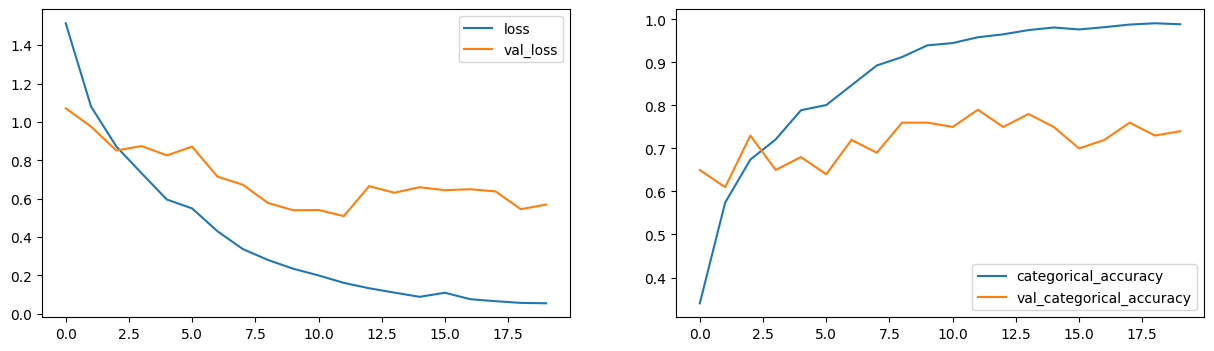

In [ ]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

## Model 16 - Let us bring in Transfer Learning !! :)
__(Optional)__

In [ ]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space
# in the nimblebox.ai platform.

#from keras.applications import mobilenet

from tensorflow.keras.applications import ResNet50
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(120,120,3))
#model.add(base_model)


In [ ]:
resnet_transfer = ResNet50(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(resnet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        for layer in model.layers:
            layer.trainable = False


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 4, 4, 2048)      │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 4, 4, 2048)      │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 16, 2, 2, 2048)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 16, 8192)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       4,260,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,873,413 (106.33 MB)

 Trainable params: 4,281,605 (16.33 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 27873413
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - categorical_accuracy: 0.2404 - loss: 1.7061
Epoch 1: saving model to model_init_2025-03-1714_26_30.409414/model-00001-1.61668-0.26320-1.36596-0.39000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - categorical_accuracy: 0.2406 - loss: 1.7054 - val_categorical_accuracy: 0.3900 - val_loss: 1.3660 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - categorical_accuracy: 0.2864 - loss: 1.5239
Epoch 2: saving model to model_init_2025-03-1714_26_30.409414/model-00002-1.49318-0.30920-1.35729-0.41000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 89s 674ms/step - categorical_accuracy: 0.2865 - loss: 1.5237 - val_categorical_accuracy: 0.4100 - val_loss: 1.3573 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - categorical_accuracy: 0.3549 - loss: 1.4338
Epoch 3: saving model to model_init_2025-03-1714_26_30.409414/model-00003-1.40132-0.38537-1.31010-0.42000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - categorical_accuracy: 0.3551 - loss: 1.4336 - val_categorical_accuracy: 0.4200 - val_loss: 1.3101 - learning_rate: 0.0010
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - categorical_accuracy: 0.3812 - loss: 1.3757
Epoch 4: saving model to model_init_2025-03-1714_26_30.409414/model-00004-1.38786-0.37255-1.26144-0.54000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 638ms/step - categorical_accuracy: 0.3811 - loss: 1.3758 - val_categorical_accuracy: 0.5400 - val_loss: 1.2614 - learning_rate: 0.0010
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - categorical_accuracy: 0.4144 - loss: 1.3575
Epoch 5: saving model to model_init_2025-03-1714_26_30.409414/model-00005-1.34083-0.41327-1.33960-0.43000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 86s 647ms/step - categorical_accuracy: 0.4144 - loss: 1.3574 - val_categorical_accuracy: 0.4300 - val_loss: 1.3396 - learning_rate: 0.0010
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - categorical_accuracy: 0.4257 - loss: 1.3755
Epoch 6: saving model to model_init_2025-03-1714_26_30.409414/model-00006-1.33531-0.42081-1.23279-0.46000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - categorical_accuracy: 0.4256 - loss: 1.3752 - val_categorical_accuracy: 0.4600 - val_loss: 1.2328 - learning_rate: 0.0010
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - categorical_accuracy: 0.4354 - loss: 1.3255
Epoch 7: saving model to model_init_2025-03-1714_26_30.409414/model-00007-1.28724-0.45173-1.25812-0.47000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - categorical_accuracy: 0.4355 - loss: 1.3252 - val_categorical_accuracy: 0.4700 - val_loss: 1.2581 - learning_rate: 0.0010
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - categorical_accuracy: 0.4742 - loss: 1.2645
Epoch 8: saving model to model_init_2025-03-1714_26_30.409414/model-00008-1.24007-0.47134-1.29651-0.46000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 86s 650ms/step - categorical_accuracy: 0.4742 - loss: 1.2643 - val_categorical_accuracy: 0.4600 - val_loss: 1.2965 - learning_rate: 0.0010
Epoch 9/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - categorical_accuracy: 0.4909 - loss: 1.2376
Epoch 9: saving model to model_init_2025-03-1714_26_30.409414/model-00009-1.22884-0.49849-1.28437-0.47000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - categorical_accuracy: 0.4910 - loss: 1.2375 - val_categorical_accuracy: 0.4700 - val_loss: 1.2844 - learning_rate: 0.0010
Epoch 10/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - categorical_accuracy: 0.5058 - loss: 1.1886
Epoch 10: saving model to model_init_2025-03-1714_26_30.409414/model-00010-1.19626-0.50603-1.35408-0.43000.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
133/133 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - categorical_accuracy: 0.5058 - loss: 1.1887 - val_categorical_accuracy: 0.4300 - val_loss: 1.3541 - learning_rate: 0.0010
Epoch 11/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - categorical_accuracy: 0.5482 - loss: 1.1247
Epoch 11: saving model to model_init_2025-03-1714_26_30.409414/model-00011-1.10532-0.56863-1.26784-0.51000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - categorical_accuracy: 0.5484 - loss: 1.1245 - val_categorical_accuracy: 0.5100 - val_loss: 1.2678 - learning_rate: 2.0000e-04
Epoch 12/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - categorical_accuracy: 0.5680 - loss: 1.0712
Epoch 12: saving model to model_init_2025-03-1714_26_30.409414/model-00012-1.09443-0.56109-1.28095-0.51000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - categorical_accuracy: 0.5679 - loss: 1.0714 - val_categorical_accuracy: 0.5100 - val_loss: 1.2809 - learning_rate: 2.0000e-04
Epoch 13/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - categorical_accuracy: 0.5716 - loss: 1.0566
Epoch 13: saving model to model_init_2025-03-1714_26_30.409414/model-00013-1.05891-0.58446-1.16311-0.52000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 643ms/step - categorical_accuracy: 0.5717 - loss: 1.0567 - val_categorical_accuracy: 0.5200 - val_loss: 1.1631 - learning_rate: 2.0000e-04
Epoch 14/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - categorical_accuracy: 0.5840 - loss: 1.0744
Epoch 14: saving model to model_init_2025-03-1714_26_30.409414/model-00014-1.04776-0.59351-1.22985-0.52000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - categorical_accuracy: 0.5840 - loss: 1.0742 - val_categorical_accuracy: 0.5200 - val_loss: 1.2299 - learning_rate: 2.0000e-04
Epoch 15/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - categorical_accuracy: 0.5771 - loss: 1.0585
Epoch 15: saving model to model_init_2025-03-1714_26_30.409414/model-00015-1.02885-0.59879-1.26329-0.49000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 641ms/step - categorical_accuracy: 0.5773 - loss: 1.0583 - val_categorical_accuracy: 0.4900 - val_loss: 1.2633 - learning_rate: 2.0000e-04
Epoch 16/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - categorical_accuracy: 0.5788 - loss: 1.0763
Epoch 16: saving model to model_init_2025-03-1714_26_30.409414/model-00016-1.02506-0.59729-1.24705-0.52000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - categorical_accuracy: 0.5789 - loss: 1.0759 - val_categorical_accuracy: 0.5200 - val_loss: 1.2470 - learning_rate: 2.0000e-04
Epoch 17/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - categorical_accuracy: 0.5933 - loss: 1.0182
Epoch 17: saving model to model_init_2025-03-1714_26_30.409414/model-00017-1.00724-0.61538-1.24926-0.50000.h5



Epoch 17: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
133/133 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - categorical_accuracy: 0.5935 - loss: 1.0181 - val_categorical_accuracy: 0.5000 - val_loss: 1.2493 - learning_rate: 2.0000e-04
Epoch 18/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - categorical_accuracy: 0.6191 - loss: 0.9238
Epoch 18: saving model to model_init_2025-03-1714_26_30.409414/model-00018-0.95797-0.61312-1.23454-0.50000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 645ms/step - categorical_accuracy: 0.6190 - loss: 0.9240 - val_categorical_accuracy: 0.5000 - val_loss: 1.2345 - learning_rate: 4.0000e-05
Epoch 19/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - categorical_accuracy: 0.6758 - loss: 0.9200
Epoch 19: saving model to model_init_2025-03-1714_26_30.409414/model-00019-0.95404-0.64178-1.30363-0.48000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 641ms/step - categorical_accuracy: 0.6755 - loss: 0.9202 - val_categorical_accuracy: 0.4800 - val_loss: 1.3036 - learning_rate: 4.0000e-05
Epoch 20/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - categorical_accuracy: 0.6144 - loss: 0.9729
Epoch 20: saving model to model_init_2025-03-1714_26_30.409414/model-00020-0.97037-0.61916-1.22636-0.52000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 85s 638ms/step - categorical_accuracy: 0.6144 - loss: 0.9729 - val_categorical_accuracy: 0.5200 - val_loss: 1.2264 - learning_rate: 4.0000e-05


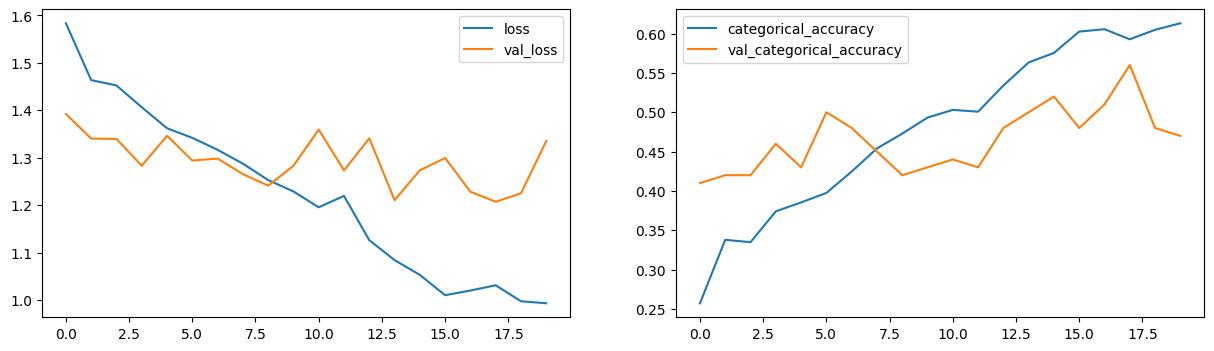

In [ ]:
plot(history_model16)

##### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 17 - Transfer Learning with GRU and training all weights
__(Optional)__

In [ ]:
#from keras.applications import mobilenet
from tensorflow.keras.applications import ResNet50

resnet_transfer = ResNet50(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):

    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(resnet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_8 (TimeDistributed) │ (None, 16, 4, 4, 2048)      │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 16, 4, 4, 2048)      │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 16, 2, 2, 2048)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 16, 8192)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │       3,195,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,808,709 (102.27 MB)

 Trainable params: 26,751,493 (102.05 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 26808709
Epoch 1/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2410 - loss: 1.7826
Epoch 1: saving model to model_init_2025-03-1715_16_09.715372/model-00001-1.64715-0.28054-1.74780-0.25000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - categorical_accuracy: 0.2413 - loss: 1.7816 - val_categorical_accuracy: 0.2500 - val_loss: 1.7478 - learning_rate: 0.0010
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3278 - loss: 1.5775
Epoch 2: saving model to model_init_2025-03-1715_16_09.715372/model-00002-1.59187-0.30769-1.53748-0.31000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - categorical_accuracy: 0.3277 - loss: 1.5776 - val_categorical_accuracy: 0.3100 - val_loss: 1.5375 - learning_rate: 0.0010
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3528 - loss: 1.4666
Epoch 3: saving model to model_init_2025-03-1715_16_09.715372/model-00003-1.46178-0.35596-1.54882-0.24000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - categorical_accuracy: 0.3529 - loss: 1.4666 - val_categorical_accuracy: 0.2400 - val_loss: 1.5488 - learning_rate: 0.0010
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3265 - loss: 1.5545
Epoch 4: saving model to model_init_2025-03-1715_16_09.715372/model-00004-1.54426-0.32353-1.44800-0.42000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - categorical_accuracy: 0.3264 - loss: 1.5545 - val_categorical_accuracy: 0.4200 - val_loss: 1.4480 - learning_rate: 0.0010
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4262 - loss: 1.4262
Epoch 5: saving model to model_init_2025-03-1715_16_09.715372/model-00005-1.46229-0.37632-1.43541-0.33000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - categorical_accuracy: 0.4258 - loss: 1.4264 - val_categorical_accuracy: 0.3300 - val_loss: 1.4354 - learning_rate: 0.0010
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3303 - loss: 1.5439
Epoch 6: saving model to model_init_2025-03-1715_16_09.715372/model-00006-1.43969-0.36501-1.22569-0.45000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - categorical_accuracy: 0.3306 - loss: 1.5431 - val_categorical_accuracy: 0.4500 - val_loss: 1.2257 - learning_rate: 0.0010
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4022 - loss: 1.3944
Epoch 7: saving model to model_init_2025-03-1715_16_09.715372/model-00007-1.34561-0.43288-1.26971-0.51000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - categorical_accuracy: 0.4024 - loss: 1.3940 - val_categorical_accuracy: 0.5100 - val_loss: 1.2697 - learning_rate: 0.0010
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4007 - loss: 1.4264
Epoch 8: saving model to model_init_2025-03-1715_16_09.715372/model-00008-1.40072-0.41327-1.45066-0.44000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - categorical_accuracy: 0.4008 - loss: 1.4262 - val_categorical_accuracy: 0.4400 - val_loss: 1.4507 - learning_rate: 0.0010
Epoch 9/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3748 - loss: 1.4024
Epoch 9: saving model to model_init_2025-03-1715_16_09.715372/model-00009-1.45810-0.36501-1.50252-0.35000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - categorical_accuracy: 0.3747 - loss: 1.4028 - val_categorical_accuracy: 0.3500 - val_loss: 1.5025 - learning_rate: 0.0010
Epoch 10/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3654 - loss: 1.4339
Epoch 10: saving model to model_init_2025-03-1715_16_09.715372/model-00010-1.38673-0.39668-1.24332-0.48000.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
133/133 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - categorical_accuracy: 0.3656 - loss: 1.4335 - val_categorical_accuracy: 0.4800 - val_loss: 1.2433 - learning_rate: 0.0010
Epoch 11/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4600 - loss: 1.2628
Epoch 11: saving model to model_init_2025-03-1715_16_09.715372/model-00011-1.27786-0.44796-1.13061-0.51000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - categorical_accuracy: 0.4599 - loss: 1.2630 - val_categorical_accuracy: 0.5100 - val_loss: 1.1306 - learning_rate: 2.0000e-04
Epoch 12/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5184 - loss: 1.1726
Epoch 12: saving model to model_init_2025-03-1715_16_09.715372/model-00012-1.16274-0.51282-1.04868-0.56000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - categorical_accuracy: 0.5183 - loss: 1.1725 - val_categorical_accuracy: 0.5600 - val_loss: 1.0487 - learning_rate: 2.0000e-04
Epoch 13/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5336 - loss: 1.1546
Epoch 13: saving model to model_init_2025-03-1715_16_09.715372/model-00013-1.09795-0.56184-1.04786-0.57000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - categorical_accuracy: 0.5338 - loss: 1.1542 - val_categorical_accuracy: 0.5700 - val_loss: 1.0479 - learning_rate: 2.0000e-04
Epoch 14/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5664 - loss: 1.0577
Epoch 14: saving model to model_init_2025-03-1715_16_09.715372/model-00014-1.04674-0.57919-0.97070-0.54000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - categorical_accuracy: 0.5665 - loss: 1.0576 - val_categorical_accuracy: 0.5400 - val_loss: 0.9707 - learning_rate: 2.0000e-04
Epoch 15/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5995 - loss: 1.0228
Epoch 15: saving model to model_init_2025-03-1715_16_09.715372/model-00015-1.04085-0.58597-0.90339-0.62000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - categorical_accuracy: 0.5994 - loss: 1.0229 - val_categorical_accuracy: 0.6200 - val_loss: 0.9034 - learning_rate: 2.0000e-04
Epoch 16/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5912 - loss: 1.0359
Epoch 16: saving model to model_init_2025-03-1715_16_09.715372/model-00016-1.06040-0.56938-0.96616-0.59000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - categorical_accuracy: 0.5910 - loss: 1.0361 - val_categorical_accuracy: 0.5900 - val_loss: 0.9662 - learning_rate: 2.0000e-04
Epoch 17/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5946 - loss: 0.9847
Epoch 17: saving model to model_init_2025-03-1715_16_09.715372/model-00017-0.98090-0.60784-0.95431-0.60000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - categorical_accuracy: 0.5947 - loss: 0.9847 - val_categorical_accuracy: 0.6000 - val_loss: 0.9543 - learning_rate: 2.0000e-04
Epoch 18/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6552 - loss: 0.8885
Epoch 18: saving model to model_init_2025-03-1715_16_09.715372/model-00018-0.86642-0.67119-0.91873-0.59000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - categorical_accuracy: 0.6554 - loss: 0.8883 - val_categorical_accuracy: 0.5900 - val_loss: 0.9187 - learning_rate: 2.0000e-04
Epoch 19/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6498 - loss: 0.8684
Epoch 19: saving model to model_init_2025-03-1715_16_09.715372/model-00019-0.86306-0.65385-0.78138-0.65000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - categorical_accuracy: 0.6499 - loss: 0.8683 - val_categorical_accuracy: 0.6500 - val_loss: 0.7814 - learning_rate: 2.0000e-04
Epoch 20/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6834 - loss: 0.8119
Epoch 20: saving model to model_init_2025-03-1715_16_09.715372/model-00020-0.81345-0.67647-0.80324-0.72000.h5


133/133 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - categorical_accuracy: 0.6834 - loss: 0.8119 - val_categorical_accuracy: 0.7200 - val_loss: 0.8032 - learning_rate: 2.0000e-04


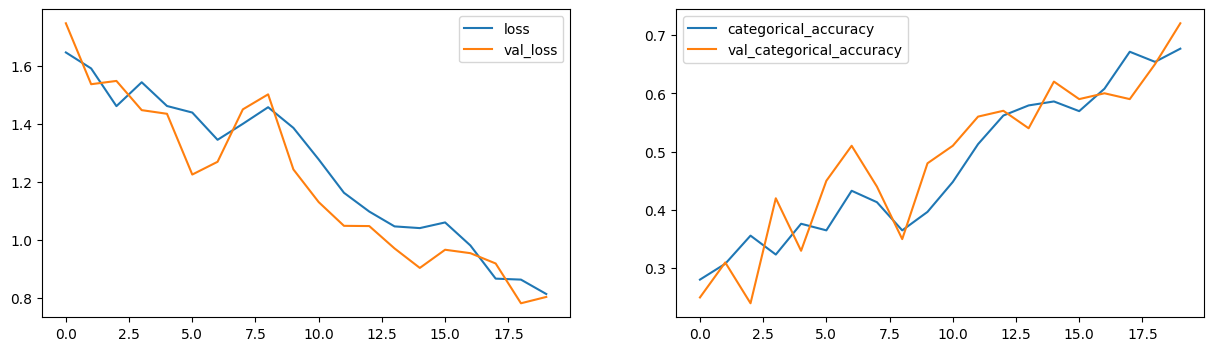

In [ ]:
plot(history_model17)

### Moderate results! 68% Training accuracy and 72% validation accuracy :)

# Consolidated Final Models

## After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.

![image.png]()

__Reason:__

__- (Training Accuracy : 91%, Validation Accuracy : 87%)__

__- Number of Parameters(999,525)less according to other models performance__

__- Learning rate gradually decreacing after 16 Epoch__


__The best weights of CNN-LSTM: model-00017-0.28423-0.89367-0.38356-0.87000.h5 (11.57 MB). I considered this weight for model testing, Let's have look at the performance below__


# Loading model and Testing

In [31]:
import time
from keras.models import load_model
model = load_model('model-00017-0.28423-0.89367-0.38356-0.87000.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[4 2 0 2 1 4 3 4 3 3 2 2 0 3 3 2 2 4 4 3]


# PG Diploma in Machine Learning and AI from IIIT Bangalore | Upgrad

#### Developed by:
##### 1. Shubhabrata Paul Choudhury

#### DS C68

